## Problem statement:
Company "Surprise Housing" wants to enter Australian market. Their business model is to buy houses at lesser price renovate and sell it to higher prices. They have collected some attributes and housing price to understand how the attributes influence the housing price and also to predict the house price given the attributes. Therefore it is important to have a generalized model where the influence of the attributes can be explained clearly (having model with correlated attributes) and prediction of the house prices can be made with good accuracy

Outcome of the model shall be used by management for further buisness adjustments

Input is provided .csv format with data dictionary attached to it

#### Approach:
1. EDA --> Understand the data. Address quality issues for it to be used in modelling
2. Modelling --> Linear regression will be applied as expected in asignment
                 Checking the asumptions of the Linear relationship between predictors and reaction variable
                 Applying the general LR model without regularization but with coarse and fine tuning of the predictors
3. Model evaluation --> Evaluating the residuals for the confirmation of linear fit assumption. Any violation found will be relooked to apply polynomial or data transformation approach
4. Ridge regularization approach and repeat the modelling the evaulation
5. Lasso regularization approach and repear the modelling and evaluation
6. Conclude the results

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

80 predictors, few have them have high null values

#### Null value propotion identification

In [3]:
# Function to identify the predictors with null value higher than "Null_P" percentage
Null_P = 15
func = lambda x:x.name if ((100 * x.isnull().sum()/1460) > Null_P) else "Valid"
invalid_column_names = df.apply(func)
invalid_column_names

Id                     Valid
MSSubClass             Valid
MSZoning               Valid
LotFrontage      LotFrontage
LotArea                Valid
                    ...     
MoSold                 Valid
YrSold                 Valid
SaleType               Valid
SaleCondition          Valid
SalePrice              Valid
Length: 81, dtype: object

In [4]:
columns_drop = invalid_column_names[invalid_column_names != "Valid"]
columns_drop

LotFrontage    LotFrontage
Alley                Alley
FireplaceQu    FireplaceQu
PoolQC              PoolQC
Fence                Fence
MiscFeature    MiscFeature
dtype: object

NA's in variables Allye, FireplaceQu, PoolQC, Fence, MiscFeature has meaning and should not be droped from the analysis

In [5]:
# Percentage of null values in "LotFrontage" predictor
100 * df["LotFrontage"].isna().sum()/df.shape[0]

17.73972602739726

"LotFrontage" predictor variable have high percentage of null values. Significance of the variable is not known. It will be verified in individual variable analysis

## Exploratory Data Analysis

- Missing value imputation
- Meta data understanding
- Data distribution
- Data conversion as required for modelling 

All the above steps are considered at individual variable level

#### Analysis of predictor "LotFrontage" --> Linear feet of street connected to property

In [6]:
df["LotFrontage"].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

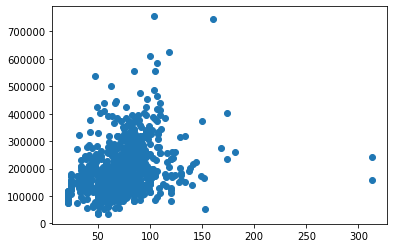

In [7]:
plt.figure()
plt.scatter(df["LotFrontage"],df["SalePrice"])

Predictor "LotFrontage" seems significant variable for prediction. Dropping whole column may not be a correct idea. Imputing it with median (safest way to avoid biasing) will be made

In [8]:
# Missing value imputation
df["LotFrontage"].fillna(df["LotFrontage"].median(),inplace=True)

In [9]:
df["LotFrontage"].isna().sum()

0

In [10]:
# Building list of numeric vars
num_vars = []
num_vars.append("LotFrontage")

#### Analysis of predictor "Id"

In [11]:
df["Id"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Id
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [12]:
df["Id"].describe()

count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64

In [13]:
df["Id"].head(20)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
18    19
19    20
Name: Id, dtype: int64

Id are the ID's of the each data point/row. This doesnt help us in the prediction. This will be dropped for further analysis

In [14]:
df.drop(labels="Id",inplace=True,axis = "columns")

#### Analysis of predictor "MSSubClass"

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES


In [15]:
df["MSSubClass"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: MSSubClass
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [16]:
df["MSSubClass"].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [17]:
# This is an unordinal encoding variable. Eventhough it is numerically encoded, keeping it numeric doesnt make sense. Converting this into dummy variables
MSSubClass_dummies = pd.get_dummies(df["MSSubClass"], drop_first=True,prefix="MSSubClass")
df = pd.concat([df,MSSubClass_dummies],axis=1)
df.drop(labels="MSSubClass",inplace=True,axis = "columns")

#### Analysis of predictor "MSZoning" --> Identifies the general zoning classification of the sale

In [18]:
df["MSZoning"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: MSZoning
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


MSZoning is categorical unordered variable without any null values. Creating dummy variables is the next step. Data distribution between categorical values are not even but that is how the data is and no further treatment will be made

In [19]:
df["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [20]:
MSZoning_dummies = pd.get_dummies(df["MSZoning"], drop_first=True,prefix="MSZoning")

In [21]:
df = pd.concat([df,MSZoning_dummies],axis=1)
df.drop(labels="MSZoning",inplace=True,axis = "columns")

#### Analysis of predictor "LotArea" --> Lot size in square feet

In [22]:
df["LotArea"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LotArea
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


Continuous variable without any null entries.

In [23]:
df["LotArea"].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

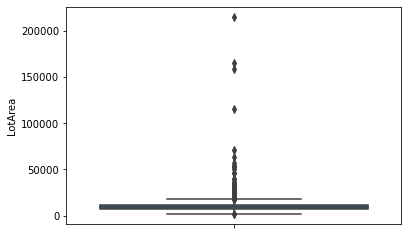

In [24]:
sns.boxplot(y=df["LotArea"])
plt.show()

In [25]:
# Building list of numeric vars
num_vars.append("LotArea")

#### Analysis of predictor "Street"--> Type of road access to property

In [26]:
df["Street"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Street
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


Lets observe the data distribution

In [27]:
df["Street"].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

Uneven data distribution between the categorical values. Create dummy variables

In [28]:
Street_dummies = pd.get_dummies(df["Street"], drop_first=True,prefix="Street")
df = pd.concat([df,Street_dummies],axis=1)
df.drop(labels="Street",inplace=True,axis = "columns")

In [29]:
df.head()

LotFrontage  LotArea Alley LotShape LandContour Utilities LotConfig  \
0         65.0     8450   NaN      Reg         Lvl    AllPub    Inside   
1         80.0     9600   NaN      Reg         Lvl    AllPub       FR2   
2         68.0    11250   NaN      IR1         Lvl    AllPub    Inside   
3         60.0     9550   NaN      IR1         Lvl    AllPub    Corner   
4         84.0    14260   NaN      IR1         Lvl    AllPub       FR2   

  LandSlope Neighborhood Condition1  ... MSSubClass_90 MSSubClass_120  \
0       Gtl      CollgCr       Norm  ...             0              0   
1       Gtl      Veenker      Feedr  ...             0              0   
2       Gtl      CollgCr       Norm  ...             0              0   
3       Gtl      Crawfor       Norm  ...             0              0   
4       Gtl      NoRidge       Norm  ...             0              0   

  MSSubClass_160  MSSubClass_180  MSSubClass_190  MSZoning_FV  MSZoning_RH  \
0              0               0               0            0            0   
1              0               0               0            0            0   
2              0               0               0            0            0   
3              0               0               0            0            0   
4              0               0               0            0            0   

  MSZoning_RL MSZoning_RM Street_Pave  
0           1           0           1  
1           1           0           1  
2           1           0           1  
3           1           0           1  
4           1           0           1  

[5 rows x 96 columns]

#### Analysis of predictor "LotShape" --> General shape of property

In [30]:
df["LotShape"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LotShape
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [31]:
df["LotShape"].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [32]:
LotShape_dummies = pd.get_dummies(df["LotShape"], drop_first=True,prefix="LotShape")
df = pd.concat([df,LotShape_dummies],axis=1)
df.drop(labels="LotShape",inplace=True,axis = "columns")

In [33]:
df.head()

LotFrontage  LotArea Alley LandContour Utilities LotConfig LandSlope  \
0         65.0     8450   NaN         Lvl    AllPub    Inside       Gtl   
1         80.0     9600   NaN         Lvl    AllPub       FR2       Gtl   
2         68.0    11250   NaN         Lvl    AllPub    Inside       Gtl   
3         60.0     9550   NaN         Lvl    AllPub    Corner       Gtl   
4         84.0    14260   NaN         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1 Condition2  ... MSSubClass_180 MSSubClass_190  \
0      CollgCr       Norm       Norm  ...              0              0   
1      Veenker      Feedr       Norm  ...              0              0   
2      CollgCr       Norm       Norm  ...              0              0   
3      Crawfor       Norm       Norm  ...              0              0   
4      NoRidge       Norm       Norm  ...              0              0   

   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM Street_Pave  \
0            0            0            1            0           1   
1            0            0            1            0           1   
2            0            0            1            0           1   
3            0            0            1            0           1   
4            0            0            1            0           1   

  LotShape_IR2 LotShape_IR3 LotShape_Reg  
0            0            0            1  
1            0            0            1  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 98 columns]

#### Analysis of predictor "LandContour"--> Flatness of the property

In [34]:
df["LandContour"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LandContour
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [35]:
df["LandContour"].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [36]:
LandContour_dummies = pd.get_dummies(df["LandContour"], drop_first=True,prefix="LandContour")
df = pd.concat([df,LandContour_dummies],axis=1)
df.drop(labels="LandContour",inplace=True,axis = "columns")

In [37]:
df.head()

LotFrontage  LotArea Alley Utilities LotConfig LandSlope Neighborhood  \
0         65.0     8450   NaN    AllPub    Inside       Gtl      CollgCr   
1         80.0     9600   NaN    AllPub       FR2       Gtl      Veenker   
2         68.0    11250   NaN    AllPub    Inside       Gtl      CollgCr   
3         60.0     9550   NaN    AllPub    Corner       Gtl      Crawfor   
4         84.0    14260   NaN    AllPub       FR2       Gtl      NoRidge   

  Condition1 Condition2 BldgType  ... MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0       Norm       Norm     1Fam  ...           0            1            0   
1      Feedr       Norm     1Fam  ...           0            1            0   
2       Norm       Norm     1Fam  ...           0            1            0   
3       Norm       Norm     1Fam  ...           0            1            0   
4       Norm       Norm     1Fam  ...           0            1            0   

   Street_Pave  LotShape_IR2 LotShape_IR3 LotShape_Reg LandContour_HLS  \
0            1             0            0            1               0   
1            1             0            0            1               0   
2            1             0            0            0               0   
3            1             0            0            0               0   
4            1             0            0            0               0   

  LandContour_Low LandContour_Lvl  
0               0               1  
1               0               1  
2               0               1  
3               0               1  
4               0               1  

[5 rows x 100 columns]

#### Analysis of predictor "Utilities" --> Type of utilities available

In [38]:
df["Utilities"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Utilities
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [39]:
df["Utilities"].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Unordered categorical variable. Data distribution is highly uneven, Create dummies

In [40]:
Utilities_dummies = pd.get_dummies(df["Utilities"], drop_first=True,prefix="Utilities")
df = pd.concat([df,Utilities_dummies],axis=1)
df.drop(labels="Utilities",inplace=True,axis = "columns")

In [41]:
df.head()

LotFrontage  LotArea Alley LotConfig LandSlope Neighborhood Condition1  \
0         65.0     8450   NaN    Inside       Gtl      CollgCr       Norm   
1         80.0     9600   NaN       FR2       Gtl      Veenker      Feedr   
2         68.0    11250   NaN    Inside       Gtl      CollgCr       Norm   
3         60.0     9550   NaN    Corner       Gtl      Crawfor       Norm   
4         84.0    14260   NaN       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  ...  MSZoning_RL  MSZoning_RM  Street_Pave  \
0       Norm     1Fam     2Story  ...            1            0            1   
1       Norm     1Fam     1Story  ...            1            0            1   
2       Norm     1Fam     2Story  ...            1            0            1   
3       Norm     1Fam     2Story  ...            1            0            1   
4       Norm     1Fam     2Story  ...            1            0            1   

   LotShape_IR2 LotShape_IR3 LotShape_Reg LandContour_HLS LandContour_Low  \
0             0            0            1               0               0   
1             0            0            1               0               0   
2             0            0            0               0               0   
3             0            0            0               0               0   
4             0            0            0               0               0   

  LandContour_Lvl  Utilities_NoSeWa  
0               1                 0  
1               1                 0  
2               1                 0  
3               1                 0  
4               1                 0  

[5 rows x 100 columns]

#### Analysis of predictor "LotConfig" --> Lot configuration

In [42]:
df["LotConfig"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LotConfig
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [43]:
df["LotConfig"].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [44]:
LotConfig_dummies = pd.get_dummies(df["LotConfig"], drop_first=True,prefix="LotConfig")
df = pd.concat([df,LotConfig_dummies],axis=1)
df.drop(labels="LotConfig",inplace=True,axis = "columns")

#### Analysis of predictor "LandSlope" --> Slope of property

In [45]:
df["LandSlope"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LandSlope
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [46]:
df["LandSlope"].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [47]:
LandSlope_dummies = pd.get_dummies(df["LandSlope"], drop_first=True,prefix="LandSlope")
df = pd.concat([df,LandSlope_dummies],axis=1)
df.drop(labels="LandSlope",inplace=True,axis = "columns")

#### Analysis of predictor "Neighborhood" --> Physical locations within Ames city limits

In [48]:
df["Neighborhood"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Neighborhood
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [49]:
df["Neighborhood"].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Create dummies

In [50]:
Neighborhood_dummies = pd.get_dummies(df["Neighborhood"], drop_first=True,prefix="Neighborhood")
df = pd.concat([df,Neighborhood_dummies],axis=1)
df.drop(labels="Neighborhood",inplace=True,axis = "columns")

#### Analysis of predictor "Condition1" -->  Proximity to various conditions

In [51]:
df["Condition1"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Condition1
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [52]:
df["Condition1"].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [53]:
Condition1_dummies = pd.get_dummies(df["Condition1"], drop_first=True,prefix="Condition1")
df = pd.concat([df,Condition1_dummies],axis=1)
df.drop(labels="Condition1",inplace=True,axis = "columns")

#### Analysis of predictor "Condition2" --> Proximity to various conditions (if more than one is present)

In [54]:
df["Condition2"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Condition2
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [55]:
df["Condition2"].value_counts()

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [56]:
Condition2_dummies = pd.get_dummies(df["Condition2"], drop_first=True,prefix="Condition2")
df = pd.concat([df,Condition2_dummies],axis=1)
df.drop(labels="Condition2",inplace=True,axis = "columns")

#### Analysis of predictor "BldgType" --> Type of dwelling

In [57]:
df["BldgType"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BldgType
Non-Null Count  Dtype 
--------------  ----- 
1460 non-null   object
dtypes: object(1)
memory usage: 11.5+ KB


In [58]:
df["BldgType"].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Unordered categorical variable. Data distribution is not even, Create dummies

In [59]:
BldgType_dummies = pd.get_dummies(df["BldgType"], drop_first=True,prefix="BldgType")
df = pd.concat([df,BldgType_dummies],axis=1)
df.drop(labels="BldgType",inplace=True,axis = "columns")

##### Note : There is nothing much can be done for the uneven distribution data across categories of a unordered categorical variable. Only analysis that can be done is the missing values. If the available values are acceptable then create dummies. Since there are lot of categorical predictors, rest of the categorical variables shall be analyzed and dummies are created in one shot

In [60]:
Categorical_predictors = ["HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd","Foundation","Heating","CentralAir","Electrical","Functional","PavedDrive","SaleType","SaleCondition"]

In [61]:
df_subset = df.loc[:,Categorical_predictors]

In [62]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   HouseStyle     1460 non-null   object
 1   RoofStyle      1460 non-null   object
 2   RoofMatl       1460 non-null   object
 3   Exterior1st    1460 non-null   object
 4   Exterior2nd    1460 non-null   object
 5   Foundation     1460 non-null   object
 6   Heating        1460 non-null   object
 7   CentralAir     1460 non-null   object
 8   Electrical     1459 non-null   object
 9   Functional     1460 non-null   object
 10  PavedDrive     1460 non-null   object
 11  SaleType       1460 non-null   object
 12  SaleCondition  1460 non-null   object
dtypes: object(13)
memory usage: 148.4+ KB


In [63]:
df_subset = pd.get_dummies(data = df_subset,columns=Categorical_predictors, drop_first=True)
df_subset

HouseStyle_1.5Unf  HouseStyle_1Story  HouseStyle_2.5Fin  \
0                     0                  0                  0   
1                     0                  1                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     0                  0                  0   
...                 ...                ...                ...   
1455                  0                  0                  0   
1456                  0                  1                  0   
1457                  0                  0                  0   
1458                  0                  1                  0   
1459                  0                  1                  0   

      HouseStyle_2.5Unf  HouseStyle_2Story  HouseStyle_SFoyer  \
0                     0                  1                  0   
1                     0                  0                  0   
2                     0                  1                  0   
3                     0                  1                  0   
4                     0                  1                  0   
...                 ...                ...                ...   
1455                  0                  1                  0   
1456                  0                  0                  0   
1457                  0                  1                  0   
1458                  0                  0                  0   
1459                  0                  0                  0   

      HouseStyle_SLvl  RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  ...  \
0                   0                1                  0              0  ...   
1                   0                1                  0              0  ...   
2                   0                1                  0              0  ...   
3                   0                1                  0              0  ...   
4                   0                1                  0              0  ...   
...               ...              ...                ...            ...  ...   
1455                0                1                  0              0  ...   
1456                0                1                  0              0  ...   
1457                0                1                  0              0  ...   
1458                0                0                  0              1  ...   
1459                0                1                  0              0  ...   

      SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0                  0               0             0             0            1   
1                  0               0             0             0            1   
2                  0               0             0             0            1   
3                  0               0             0             0            1   
4                  0               0             0             0            1   
...              ...             ...           ...           ...          ...   
1455               0               0             0             0            1   
1456               0               0             0             0            1   
1457               0               0             0             0            1   
1458               0               0             0             0            1   
1459               0               0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ..

In [64]:
df = pd.concat([df,df_subset],axis=1)
df.drop(labels=Categorical_predictors,inplace=True,axis = "columns")
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 214 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    LotFrontage            float64
 1    LotArea                int64  
 2    Alley                  object 
 3    OverallQual            int64  
 4    OverallCond            int64  
 5    YearBuilt              int64  
 6    YearRemodAdd           int64  
 7    MasVnrType             object 
 8    MasVnrArea             float64
 9    ExterQual              object 
 10   ExterCond              object 
 11   BsmtQual               object 
 12   BsmtCond               object 
 13   BsmtExposure           object 
 14   BsmtFinType1           object 
 15   BsmtFinSF1             int64  
 16   BsmtFinType2           object 
 17   BsmtFinSF2             int64  
 18   BsmtUnfSF              int64  
 19   TotalBsmtSF            int64  
 20   HeatingQC              object 
 21   1stFlrSF               int64  
 22 

#### Following variables have high NAs but their NAs have meaning and have to be handeled properly
Alley
FireplaceQu
PoolQC
Fence
MiscFeature
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
GarageType
GarageFinish
GarageQual
GarageCond
MasVnrType

In [65]:
df["Alley"].fillna("No alley access",inplace=True)
df["FireplaceQu"].fillna("No Fireplace",inplace=True)
df["PoolQC"].fillna("No Pool",inplace=True)
df["Fence"].fillna("No Fence",inplace=True)
df["MiscFeature"].fillna("None",inplace=True)
df["BsmtQual"].fillna("No Basement",inplace=True)
df["BsmtCond"].fillna("No Basement",inplace=True)
df["BsmtExposure"].fillna("No Basement",inplace=True)
df["BsmtFinType1"].fillna("No Basement",inplace=True)
df["BsmtFinType2"].fillna("No Basement",inplace=True)
df["GarageType"].fillna("No Garage",inplace=True)
df["GarageFinish"].fillna("No Garage",inplace=True)
df["GarageQual"].fillna("No Garage",inplace=True)
df["GarageCond"].fillna("No Garage",inplace=True)
df["MasVnrType"].fillna("None Type",inplace=True)

Variables "BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond, PoolQC, ExterQual, ExterCond" are ordinal categorical in nature. All of these will be conveted numeric values to check the linear relationship

In [66]:
df.BsmtQual = df.BsmtQual.map({"Ex":6,"Gd":5,"TA":4,"Fa":3,"Po":2,"No Basement":1})
num_vars.append("BsmtQual")

In [67]:
df.BsmtCond = df.BsmtCond.map({"Ex":6,"Gd":5,"TA":4,"Fa":3,"Po":2,"No Basement":1})
num_vars.append("BsmtCond")

In [68]:
df.HeatingQC = df.HeatingQC.map({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1})
num_vars.append("HeatingQC")

In [69]:
df.KitchenQual = df.KitchenQual.map({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1})
num_vars.append("KitchenQual")

In [70]:
df.FireplaceQu = df.FireplaceQu.map({"Ex":6,"Gd":5,"TA":4,"Fa":3,"Po":2,"No Fireplace":1})
num_vars.append("FireplaceQu")

In [71]:
df.GarageQual = df.GarageQual.map({"Ex":6,"Gd":5,"TA":4,"Fa":3,"Po":2,"No Garage":1})
num_vars.append("GarageQual")

In [72]:
df.GarageCond = df.GarageCond.map({"Ex":6,"Gd":5,"TA":4,"Fa":3,"Po":2,"No Garage":1})
num_vars.append("GarageCond")

In [73]:
df.PoolQC = df.PoolQC.map({"Ex":5,"Gd":4,"TA":3,"Fa":2,"No Pool":1})
num_vars.append("PoolQC")

In [74]:
df.ExterQual = df.ExterQual.map({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1})
num_vars.append("ExterQual")

In [75]:
df.ExterCond = df.ExterCond.map({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1})
num_vars.append("ExterCond")

In [76]:
# Creation of the dummy variables for the remaining Nominal categorical variables
Categorical_predictors = ["Alley","Fence","MiscFeature","BsmtExposure","BsmtFinType1","BsmtFinType2","GarageType","GarageFinish","MasVnrType"]
df_subset = df.loc[:,Categorical_predictors]
df_subset = pd.get_dummies(data = df_subset,columns=Categorical_predictors, drop_first=True)
df = pd.concat([df,df_subset],axis=1)
df.drop(labels=Categorical_predictors,inplace=True,axis = "columns")

In [77]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 244 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    LotFrontage               float64
 1    LotArea                   int64  
 2    OverallQual               int64  
 3    OverallCond               int64  
 4    YearBuilt                 int64  
 5    YearRemodAdd              int64  
 6    MasVnrArea                float64
 7    ExterQual                 int64  
 8    ExterCond                 int64  
 9    BsmtQual                  int64  
 10   BsmtCond                  int64  
 11   BsmtFinSF1                int64  
 12   BsmtFinSF2                int64  
 13   BsmtUnfSF                 int64  
 14   TotalBsmtSF               int64  
 15   HeatingQC                 int64  
 16   1stFlrSF                  int64  
 17   2ndFlrSF                  int64  
 18   LowQualFinSF              int64  
 19   GrLivArea                 int64  
 20   BsmtFu

#### Analysis of quantitative variables

#### Analysis of predictor "YearBuilt" --> Original construction date

In [78]:
df["YearBuilt"].describe()

count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

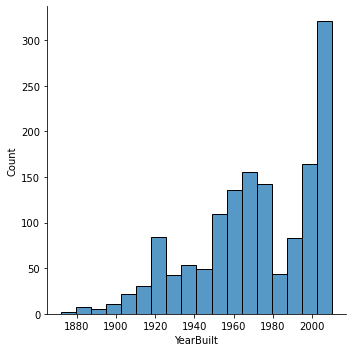

In [79]:
sns.displot(x=df["YearBuilt"])
num_vars.append("YearBuilt")

Data distribution is not normal. Since it is year information and older houser available for sale could be less. Hence no treatment is needed

#### Analysis of predictor "YearRemodAdd" --> Remodel date (same as construction date if no remodeling or additions)

In [80]:
df["YearRemodAdd"].describe()

count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

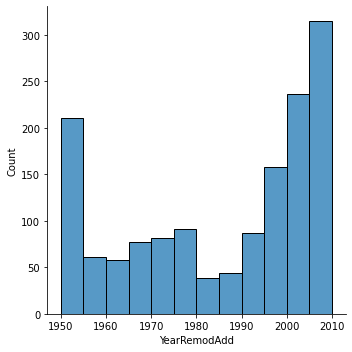

In [81]:
sns.displot(x=df["YearRemodAdd"])
# Building list of numeric vars
num_vars.append("YearRemodAdd")

In [82]:
np.corrcoef(x=df["YearRemodAdd"],y=df["YearBuilt"])

array([[1.        , 0.59285498],
       [0.59285498, 1.        ]])

#### Analysis of predictor "MasVnrArea" --> Masonry veneer area in square feet

This variable is inline with MasVnrType where none is not NA but a information. Imputing the variable MasVnrArea NAs as 0 sqft

In [83]:
df["MasVnrArea"].fillna(0,inplace = True)

In [84]:
df["MasVnrArea"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: MasVnrArea
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB


In [85]:
df["MasVnrArea"].describe()

count    1460.000000
mean      103.117123
std       180.731373
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

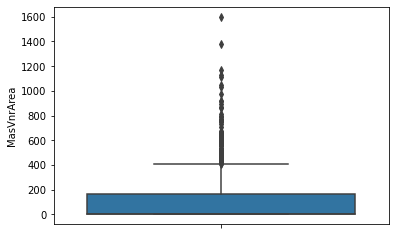

In [86]:
sns.boxplot(y=df["MasVnrArea"])
# Building list of numeric vars
num_vars.append("MasVnrArea")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "BsmtFinSF1"--> Type 1 finished square feet

In [87]:
df["BsmtFinSF1"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtFinSF1
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [88]:
df["BsmtFinSF1"].describe()

count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

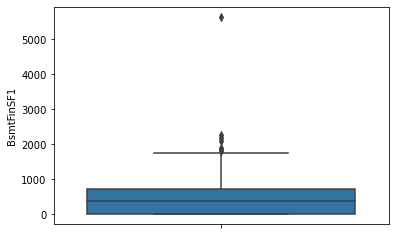

In [89]:
sns.boxplot(y=df["BsmtFinSF1"])
# Building list of numeric vars
num_vars.append("BsmtFinSF1")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "BsmtFinSF2" --> Type 2 finished square feet

In [90]:
df["BsmtFinSF2"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtFinSF2
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [91]:
df["BsmtFinSF2"].describe()

count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

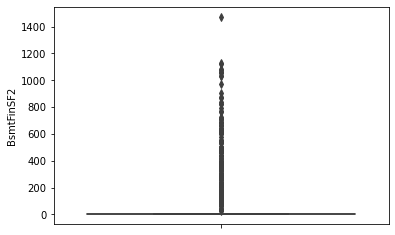

In [92]:
sns.boxplot(y=df["BsmtFinSF2"])
# Building list of numeric vars
num_vars.append("BsmtFinSF2")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "BsmtUnfSF" --> Unfinished square feet of basement area

In [93]:
df["BsmtUnfSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtUnfSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [94]:
df["BsmtUnfSF"].describe()

count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

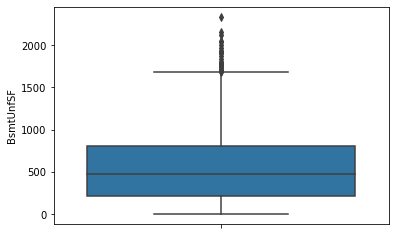

In [95]:
sns.boxplot(y=df["BsmtUnfSF"])
# Building list of numeric vars
num_vars.append("BsmtUnfSF")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "TotalBsmtSF" --> Total square feet of basement area

In [96]:
df["TotalBsmtSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: TotalBsmtSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [97]:
df["TotalBsmtSF"].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

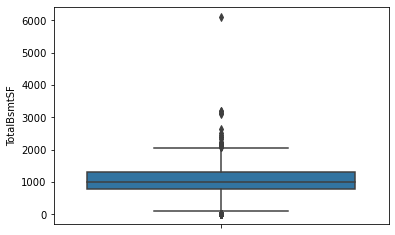

In [98]:
sns.boxplot(y=df["TotalBsmtSF"])
# Building list of numeric vars
num_vars.append("TotalBsmtSF")

All area values are under acceptable regions. No outliers hene no treatment needed

It could be possible that total basement area = furnished + unfurnished basement area. Lets check this

In [99]:
(df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["BsmtUnfSF"] == df["TotalBsmtSF"]).sum()

1460

Above code proves that they are equal. Total basement area is irrerelavant. Lets verify this in colinearity check

#### Analysis of predictor "1stFlrSF" --> First Floor square feet

In [100]:
df["1stFlrSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: 1stFlrSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [101]:
df["1stFlrSF"].describe()

count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

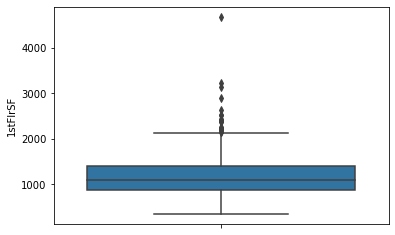

In [102]:
sns.boxplot(y=df["1stFlrSF"])
# Building list of numeric vars
num_vars.append("1stFlrSF")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "2ndFlrSF" --> Second floor square feet

In [103]:
df["2ndFlrSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: 2ndFlrSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [104]:
df["2ndFlrSF"].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

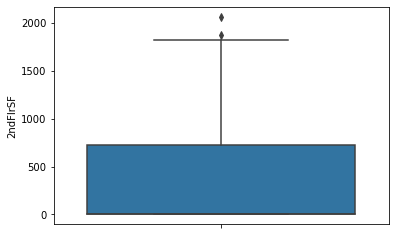

In [105]:
sns.boxplot(y=df["2ndFlrSF"])
# Building list of numeric vars
num_vars.append("2ndFlrSF")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "LowQualFinSF" --> Low quality finished square feet (all floors)

In [106]:
df["LowQualFinSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: LowQualFinSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [107]:
df["LowQualFinSF"].describe()

count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

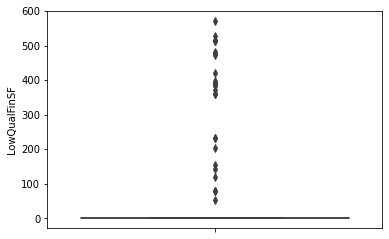

In [108]:
sns.boxplot(y=df["LowQualFinSF"])
# Building list of numeric vars
num_vars.append("LowQualFinSF")

All area values are under acceptable regions. No outliers hene no treatment needed

#### Analysis of predictor "GrLivArea" --> Above grade (ground) living area square feet

In [109]:
df["GrLivArea"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: GrLivArea
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [110]:
df["GrLivArea"].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

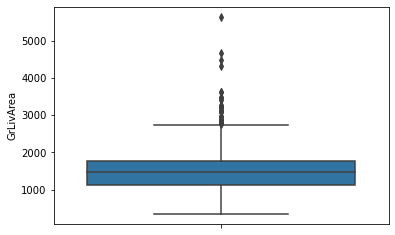

In [111]:
sns.boxplot(y=df["GrLivArea"])
# Building list of numeric vars
num_vars.append("GrLivArea")

All area values are under acceptable regions. No outliers hene no treatment needed

Lets check if sum of 1st, 2nd flr and low quality finished area sum is equal to above ground living area

In [112]:
(df["1stFlrSF"] + df["2ndFlrSF"] + df["LowQualFinSF"] == df["GrLivArea"]).sum()

1460

Above code proves that they are equal. Above grade (ground) living area square feet could be redundant. Lets verify this later

#### Analysis of predictor "BsmtFullBath" --> Basement full bathrooms

In [113]:
df["BsmtFullBath"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtFullBath
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [114]:
df["BsmtFullBath"].describe()

count    1460.000000
mean        0.425342
std         0.518911
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

<AxesSubplot:xlabel='BsmtFullBath', ylabel='Density'>

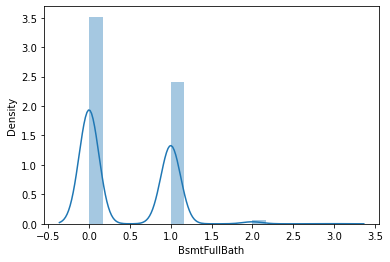

In [115]:
sns.distplot(df["BsmtFullBath"])

In [116]:
df["BsmtFullBath"].value_counts()


0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [117]:
# Building list of numeric vars
num_vars.append("BsmtFullBath")

#### Analysis of predictor "BsmtHalfBath" --> Basement half bathrooms

In [118]:
df["BsmtHalfBath"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BsmtHalfBath
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [119]:
df["BsmtHalfBath"].describe()

count    1460.000000
mean        0.057534
std         0.238753
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

In [120]:
df["BsmtHalfBath"].value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [121]:
# Building list of numeric vars
num_vars.append("BsmtHalfBath")

#### Analysis of predictor "FullBath" --> Full bathrooms above grade

In [122]:
df["FullBath"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: FullBath
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [123]:
df["FullBath"].describe()

count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

In [124]:
df["FullBath"].value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [125]:
# Building list of numeric vars
num_vars.append("FullBath")

#### Analysis of predictor "HalfBath" --> Half baths above grade

In [126]:
df["HalfBath"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: HalfBath
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [127]:
df["HalfBath"].describe()

count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64

In [128]:
df["HalfBath"].value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [129]:
# Building list of numeric vars
num_vars.append("HalfBath")

#### Analysis of predictor "BedroomAbvGr" --> Bedrooms above grade (does NOT include basement bedrooms)

In [130]:
df["BedroomAbvGr"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: BedroomAbvGr
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [131]:
df["BedroomAbvGr"].describe()

count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

In [132]:
df["BedroomAbvGr"].value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [133]:
# Building list of numeric vars
num_vars.append("BedroomAbvGr")

#### Analysis of predictor "KitchenAbvGr" --> Kitchens above grade

In [134]:
df["KitchenAbvGr"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: KitchenAbvGr
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [135]:
df["KitchenAbvGr"].describe()

count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

In [136]:
df["KitchenAbvGr"].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [137]:
# Building list of numeric vars
num_vars.append("KitchenAbvGr")

#### Analysis of predictor "TotRmsAbvGrd" --> Total rooms above grade (does not include bathrooms)

In [138]:
df["TotRmsAbvGrd"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: TotRmsAbvGrd
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [139]:
df["TotRmsAbvGrd"].value_counts()

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
2       1
14      1
Name: TotRmsAbvGrd, dtype: int64

In [140]:
# Building list of numeric vars
num_vars.append("TotRmsAbvGrd")

#### Analysis of predictor "Fireplaces" --> Number of fireplaces

In [141]:
df["Fireplaces"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: Fireplaces
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [142]:
df["Fireplaces"].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [143]:
# Building list of numeric vars
num_vars.append("Fireplaces")

#### Analysis of predictor "LotFrontage" --> Year garage was built

In [144]:
df["GarageYrBlt"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: GarageYrBlt
Non-Null Count  Dtype  
--------------  -----  
1379 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB


In [145]:
df["GarageYrBlt"].describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [146]:
df["GarageYrBlt"].value_counts()

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

<AxesSubplot:xlabel='GarageYrBlt', ylabel='Density'>

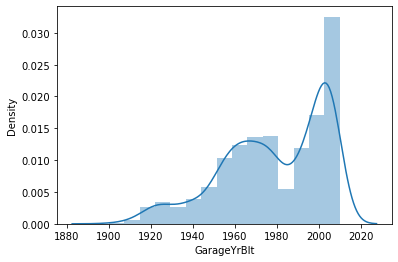

In [147]:
sns.distplot(df["GarageYrBlt"])

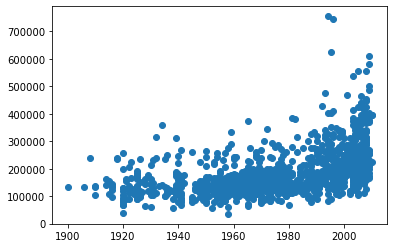

In [148]:
# There are null entries in the variable. Lets see the relationship with target variable
plt.figure()
plt.scatter(df["GarageYrBlt"],df["SalePrice"])

In [149]:
# All the NAs are for the houses that doesnt have garage. Verified in excel. It may be safe to impute the values with house year built as the variable seem to have impact on the sales
df.GarageYrBlt[df.GarageYrBlt.isna()] = df.YearBuilt[df.GarageYrBlt.isna()]
df["GarageYrBlt"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: GarageYrBlt
Non-Null Count  Dtype  
--------------  -----  
1460 non-null   float64
dtypes: float64(1)
memory usage: 11.5 KB


In [150]:
# Building list of numeric vars
num_vars.append("GarageYrBlt")

#### Analysis of predictor "GarageCars" --> Size of garage in car capacity

In [151]:
df["GarageCars"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: GarageCars
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [152]:
df["GarageCars"].value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [153]:
# Building list of numeric vars
num_vars.append("GarageCars")

#### Analysis of predictor "WoodDeckSF" --> Wood deck area in square feet

In [154]:
df["WoodDeckSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: WoodDeckSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [155]:
df["WoodDeckSF"].describe()

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

<AxesSubplot:ylabel='WoodDeckSF'>

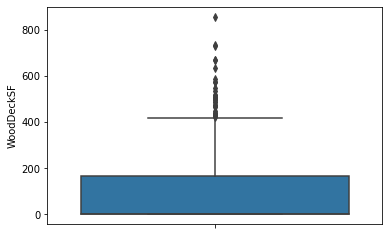

In [156]:
sns.boxplot(y=df["WoodDeckSF"])

In [157]:
# Building list of numeric vars
num_vars.append("WoodDeckSF")

No outliers . All the values in valid region. NO further treatment on this variable

#### Analysis of predictor "OpenPorchSF" -->Open porch area in square feet

In [158]:
df["OpenPorchSF"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: OpenPorchSF
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [159]:
df["OpenPorchSF"].describe()

count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

<AxesSubplot:ylabel='OpenPorchSF'>

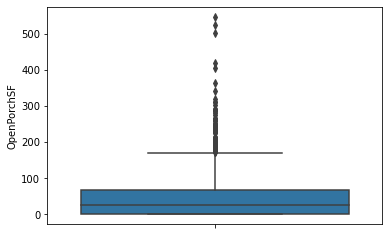

In [160]:
sns.boxplot(y=df["OpenPorchSF"])

In [161]:
# Building list of numeric vars
num_vars.append("OpenPorchSF")

No outliers . All the values in valid region. NO further treatment on this variable

#### Analysis of predictor "EnclosedPorch" --> Enclosed porch area in square feet

In [162]:
df["EnclosedPorch"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: EnclosedPorch
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [163]:
df["EnclosedPorch"].describe()

count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

<AxesSubplot:ylabel='EnclosedPorch'>

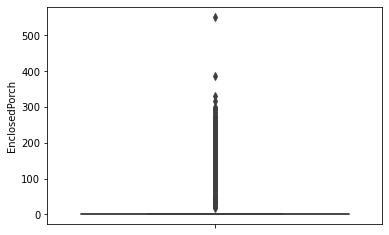

In [164]:
sns.boxplot(y=df["EnclosedPorch"])

In [165]:
# Building list of numeric vars
num_vars.append("EnclosedPorch")

No outliers . All the values in valid region. NO further treatment on this variable

#### Analysis of predictor "3SsnPorch" --> Three season porch area in square feet

In [166]:
df["3SsnPorch"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: 3SsnPorch
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [167]:
df["3SsnPorch"].describe()

count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

<AxesSubplot:ylabel='3SsnPorch'>

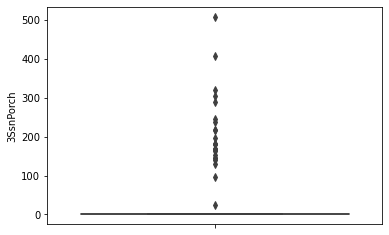

In [168]:
sns.boxplot(y=df["3SsnPorch"])

In [169]:
# Building list of numeric vars
num_vars.append("3SsnPorch")

No outliers . All the values in valid region. NO further treatment on this variable

#### Analysis of predictor "ScreenPorch" --> Screen porch area in square feet

In [170]:
df["ScreenPorch"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: ScreenPorch
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [171]:
df["ScreenPorch"].describe()

count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

<AxesSubplot:ylabel='ScreenPorch'>

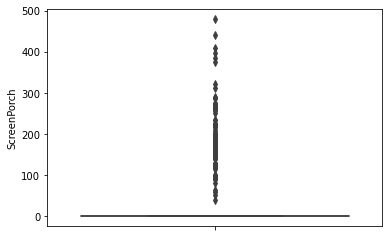

In [172]:
sns.boxplot(y=df["ScreenPorch"])

In [173]:
# Building list of numeric vars
num_vars.append("ScreenPorch")

No outliers . All the values in valid region. NO further treatment on this variable

#### Analysis of predictor "PoolArea" --> Pool area in square feet

In [174]:
df["PoolArea"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: PoolArea
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [175]:
df["PoolArea"].describe()

count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

<AxesSubplot:ylabel='PoolArea'>

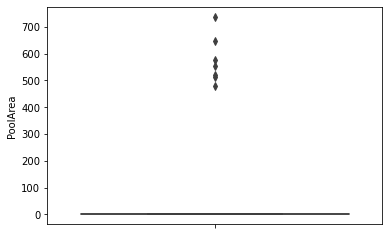

In [176]:
sns.boxplot(y=df["PoolArea"])

In [177]:
# Building list of numeric vars
num_vars.append("PoolArea")

pool area > ~500 sq ft is suspecious. But due to lack of evidence and business knowledge about the pool areas in australia, no treatment is made

#### Analysis of predictor "MiscVal" --> $ Value of miscellaneous feature

In [178]:
df["MiscVal"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: MiscVal
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [179]:
df["MiscVal"].describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

<AxesSubplot:ylabel='MiscVal'>

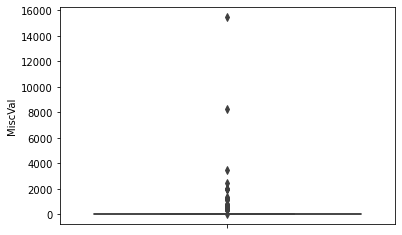

In [180]:
sns.boxplot(y=df["MiscVal"])

No business knowledge of how muach the value could be for miscellaneous items. Majority of the times the value could be not available hence the value of 0 could be more. Lets check it

In [181]:
df["MiscVal"].value_counts()

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64

In [182]:
# Building list of numeric vars
num_vars.append("MiscVal")

Since majority of the values are 0 with one very high value of 15500. Impact of this variable has to be carefully understood in the modelling stage. 

#### Analysis of predictor "MoSold" --> Month Sold (MM)

In [183]:
df["MoSold"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: MoSold
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [184]:
df["MoSold"].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [185]:
# Building list of numeric vars
num_vars.append("MoSold")

Month in which the house is sold will not be available later for the prredicton of the new houses sale value. Hence this doesnt add value in deciding the price of the house. This column will be dropped

#### Predictor "YrSold" --> Year Sold (YYYY)

Same analysis of month sold hold good

In [186]:
# Building list of numeric vars
num_vars.append("YrSold")

In [187]:
df.drop(labels=["MoSold","YrSold"],inplace=True,axis="columns")
num_vars.remove("YrSold")
num_vars.remove("MoSold")

#### Target variable "SalePrice"

In [188]:
df["SalePrice"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1460 entries, 0 to 1459
Series name: SalePrice
Non-Null Count  Dtype
--------------  -----
1460 non-null   int64
dtypes: int64(1)
memory usage: 11.5 KB


In [189]:
df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [190]:
# Building list of numeric vars
num_vars.append("SalePrice")

### Colinearity check

<AxesSubplot:>

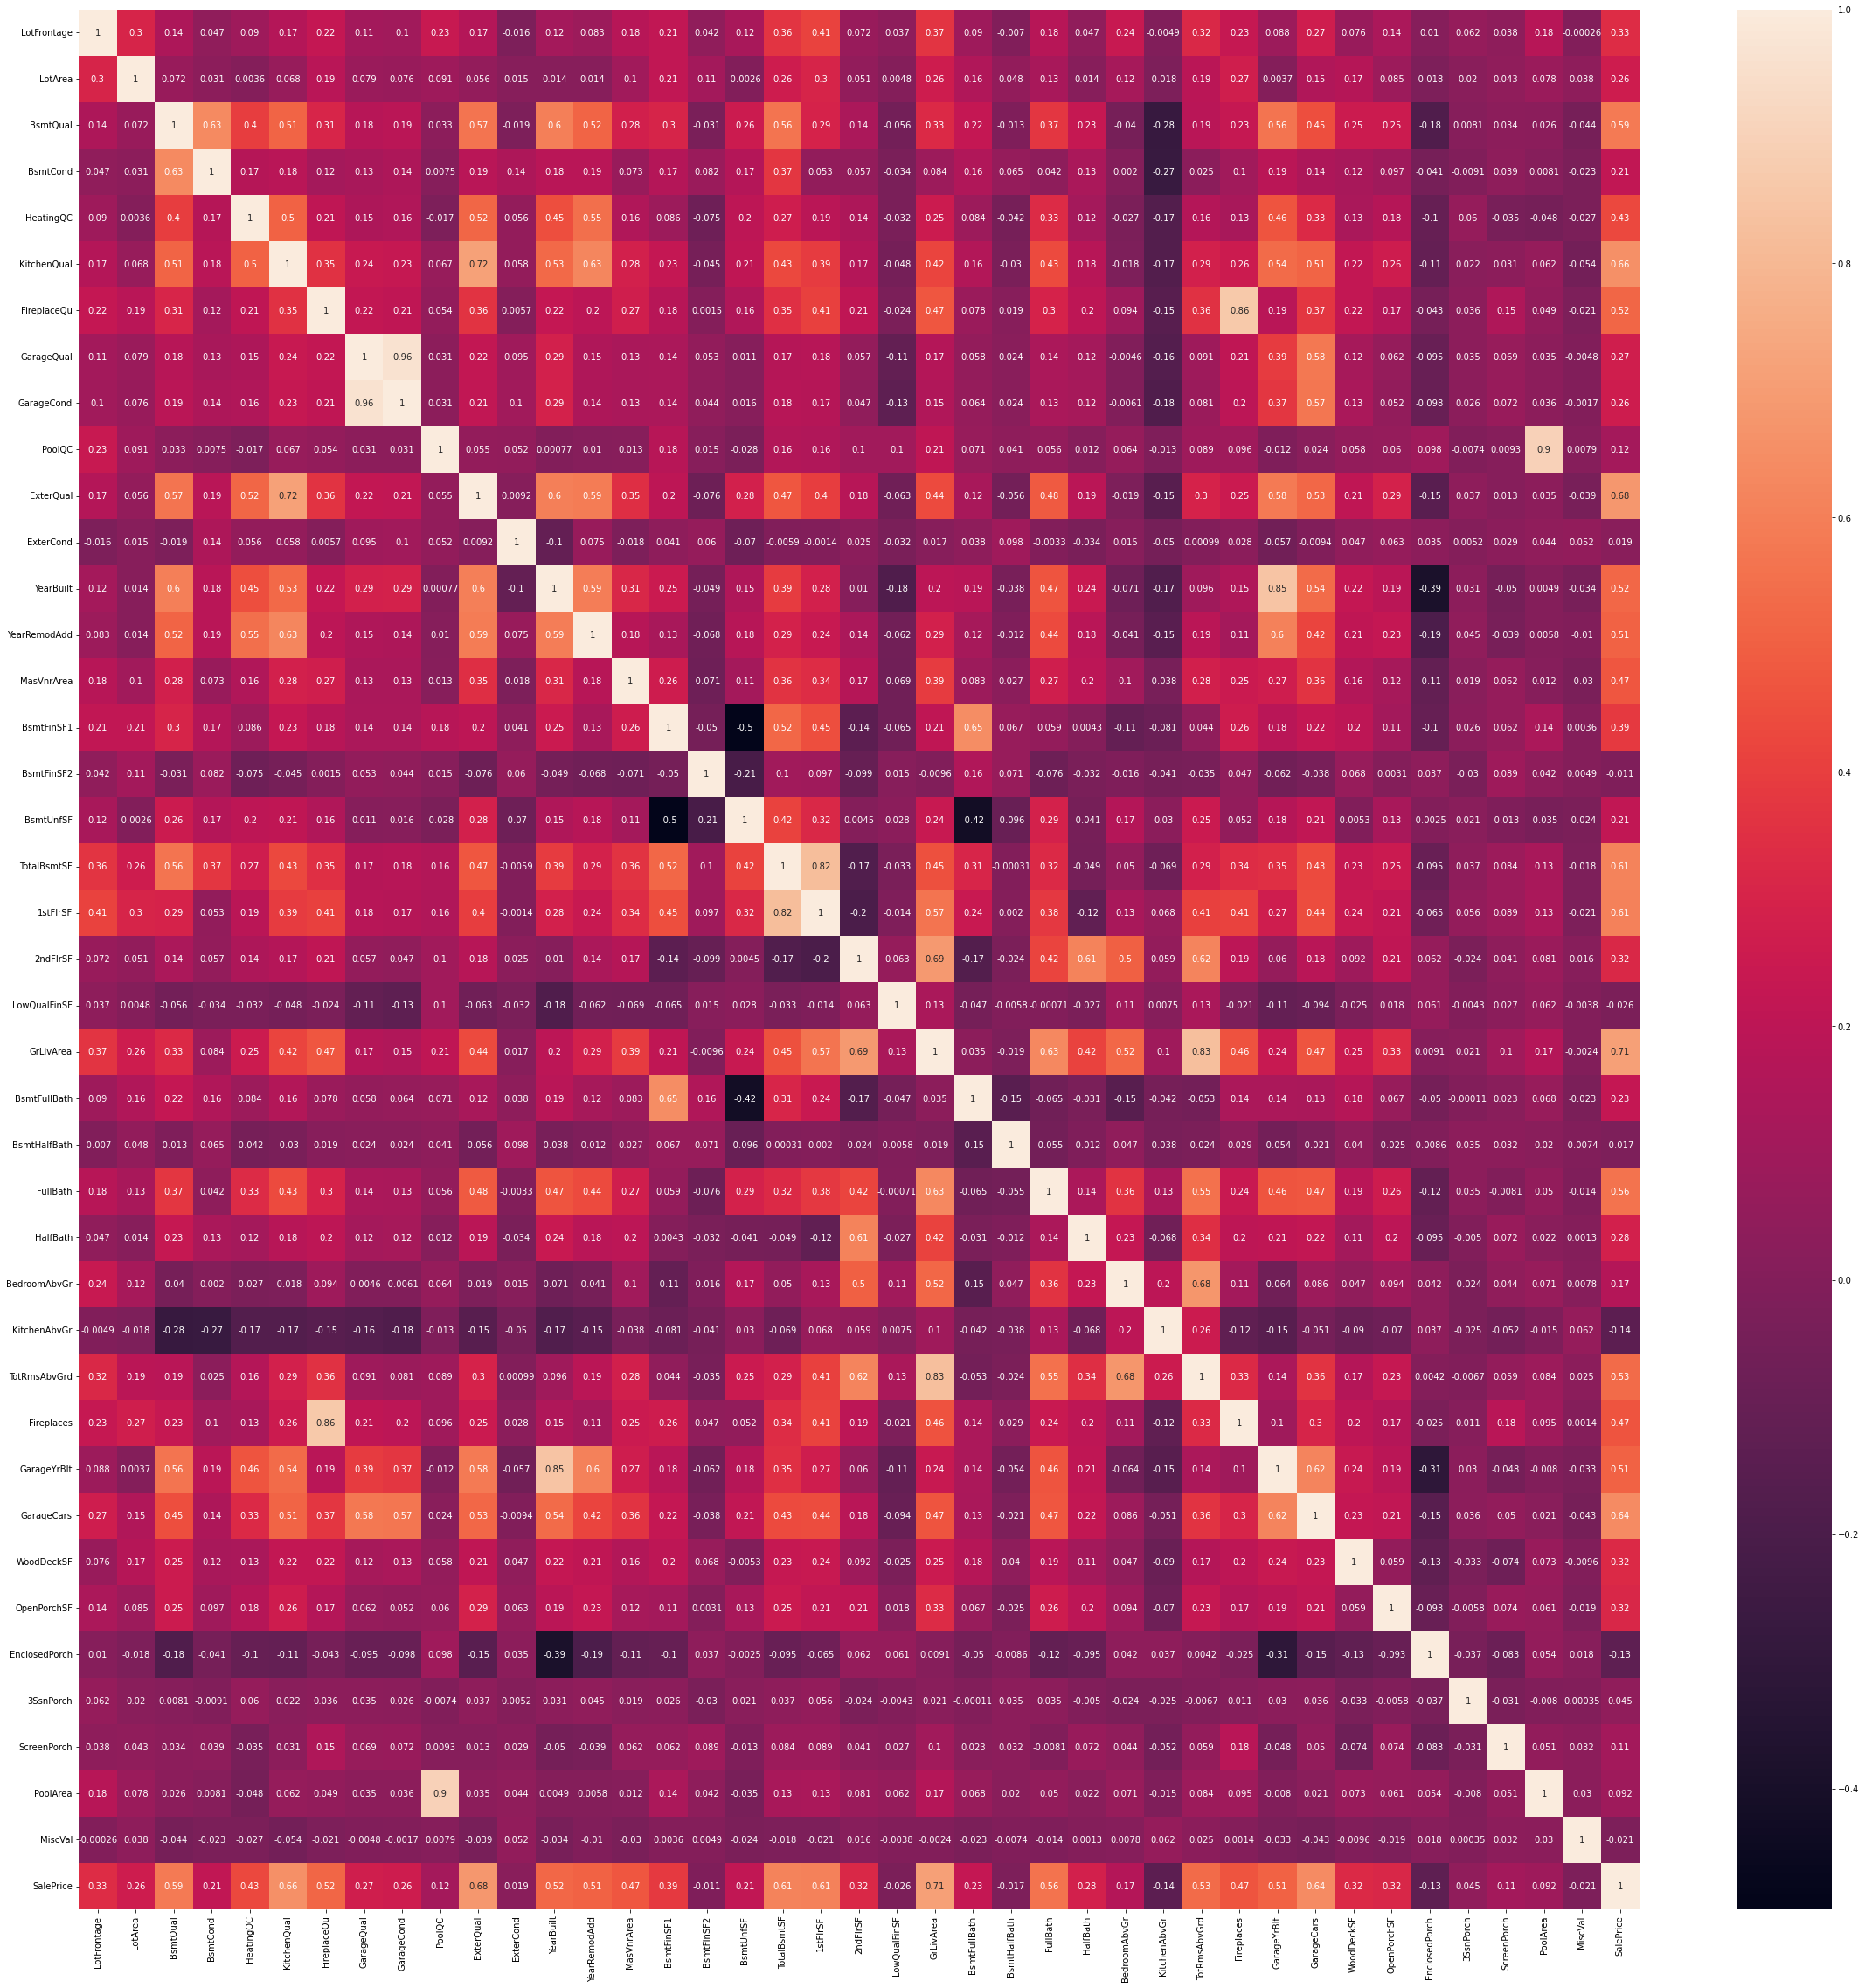

In [191]:
plt.figure(figsize=(40,40))
sns.heatmap(df.loc[:,num_vars].corr(),annot=True)

YearBuilt and GarageYrBlt are highly correlated --> GarageYrBlt shall be dropped

TotalBsmtSF and 1stFlrSF are highly correlated 

TotRmsAbvGrd and GrLivArea are highly correlated

Since (df["BsmtFinSF1"] + df["BsmtFinSF2"] + df["BsmtUnfSF"] == df["TotalBsmtSF"]) and 

(df["1stFlrSF"] + df["2ndFlrSF"] + df["LowQualFinSF"] == df["GrLivArea"])

TotalBsmtSF and GrLivArea can be dropped as they wont add any new information which inturn also eliminate multicolinearity

In [192]:
df.drop(labels=["GarageYrBlt","TotalBsmtSF","GrLivArea"],inplace=True,axis="columns")
num_vars.remove("GarageYrBlt")
num_vars.remove("TotalBsmtSF")
num_vars.remove("GrLivArea")

##### Final data frame is ready as above. Let us start with linearity assumption check

Since the number of variable are huge, Lets first understand the linear relation ship between qantitative variables and target variable

<Figure size 2880x2880 with 0 Axes>

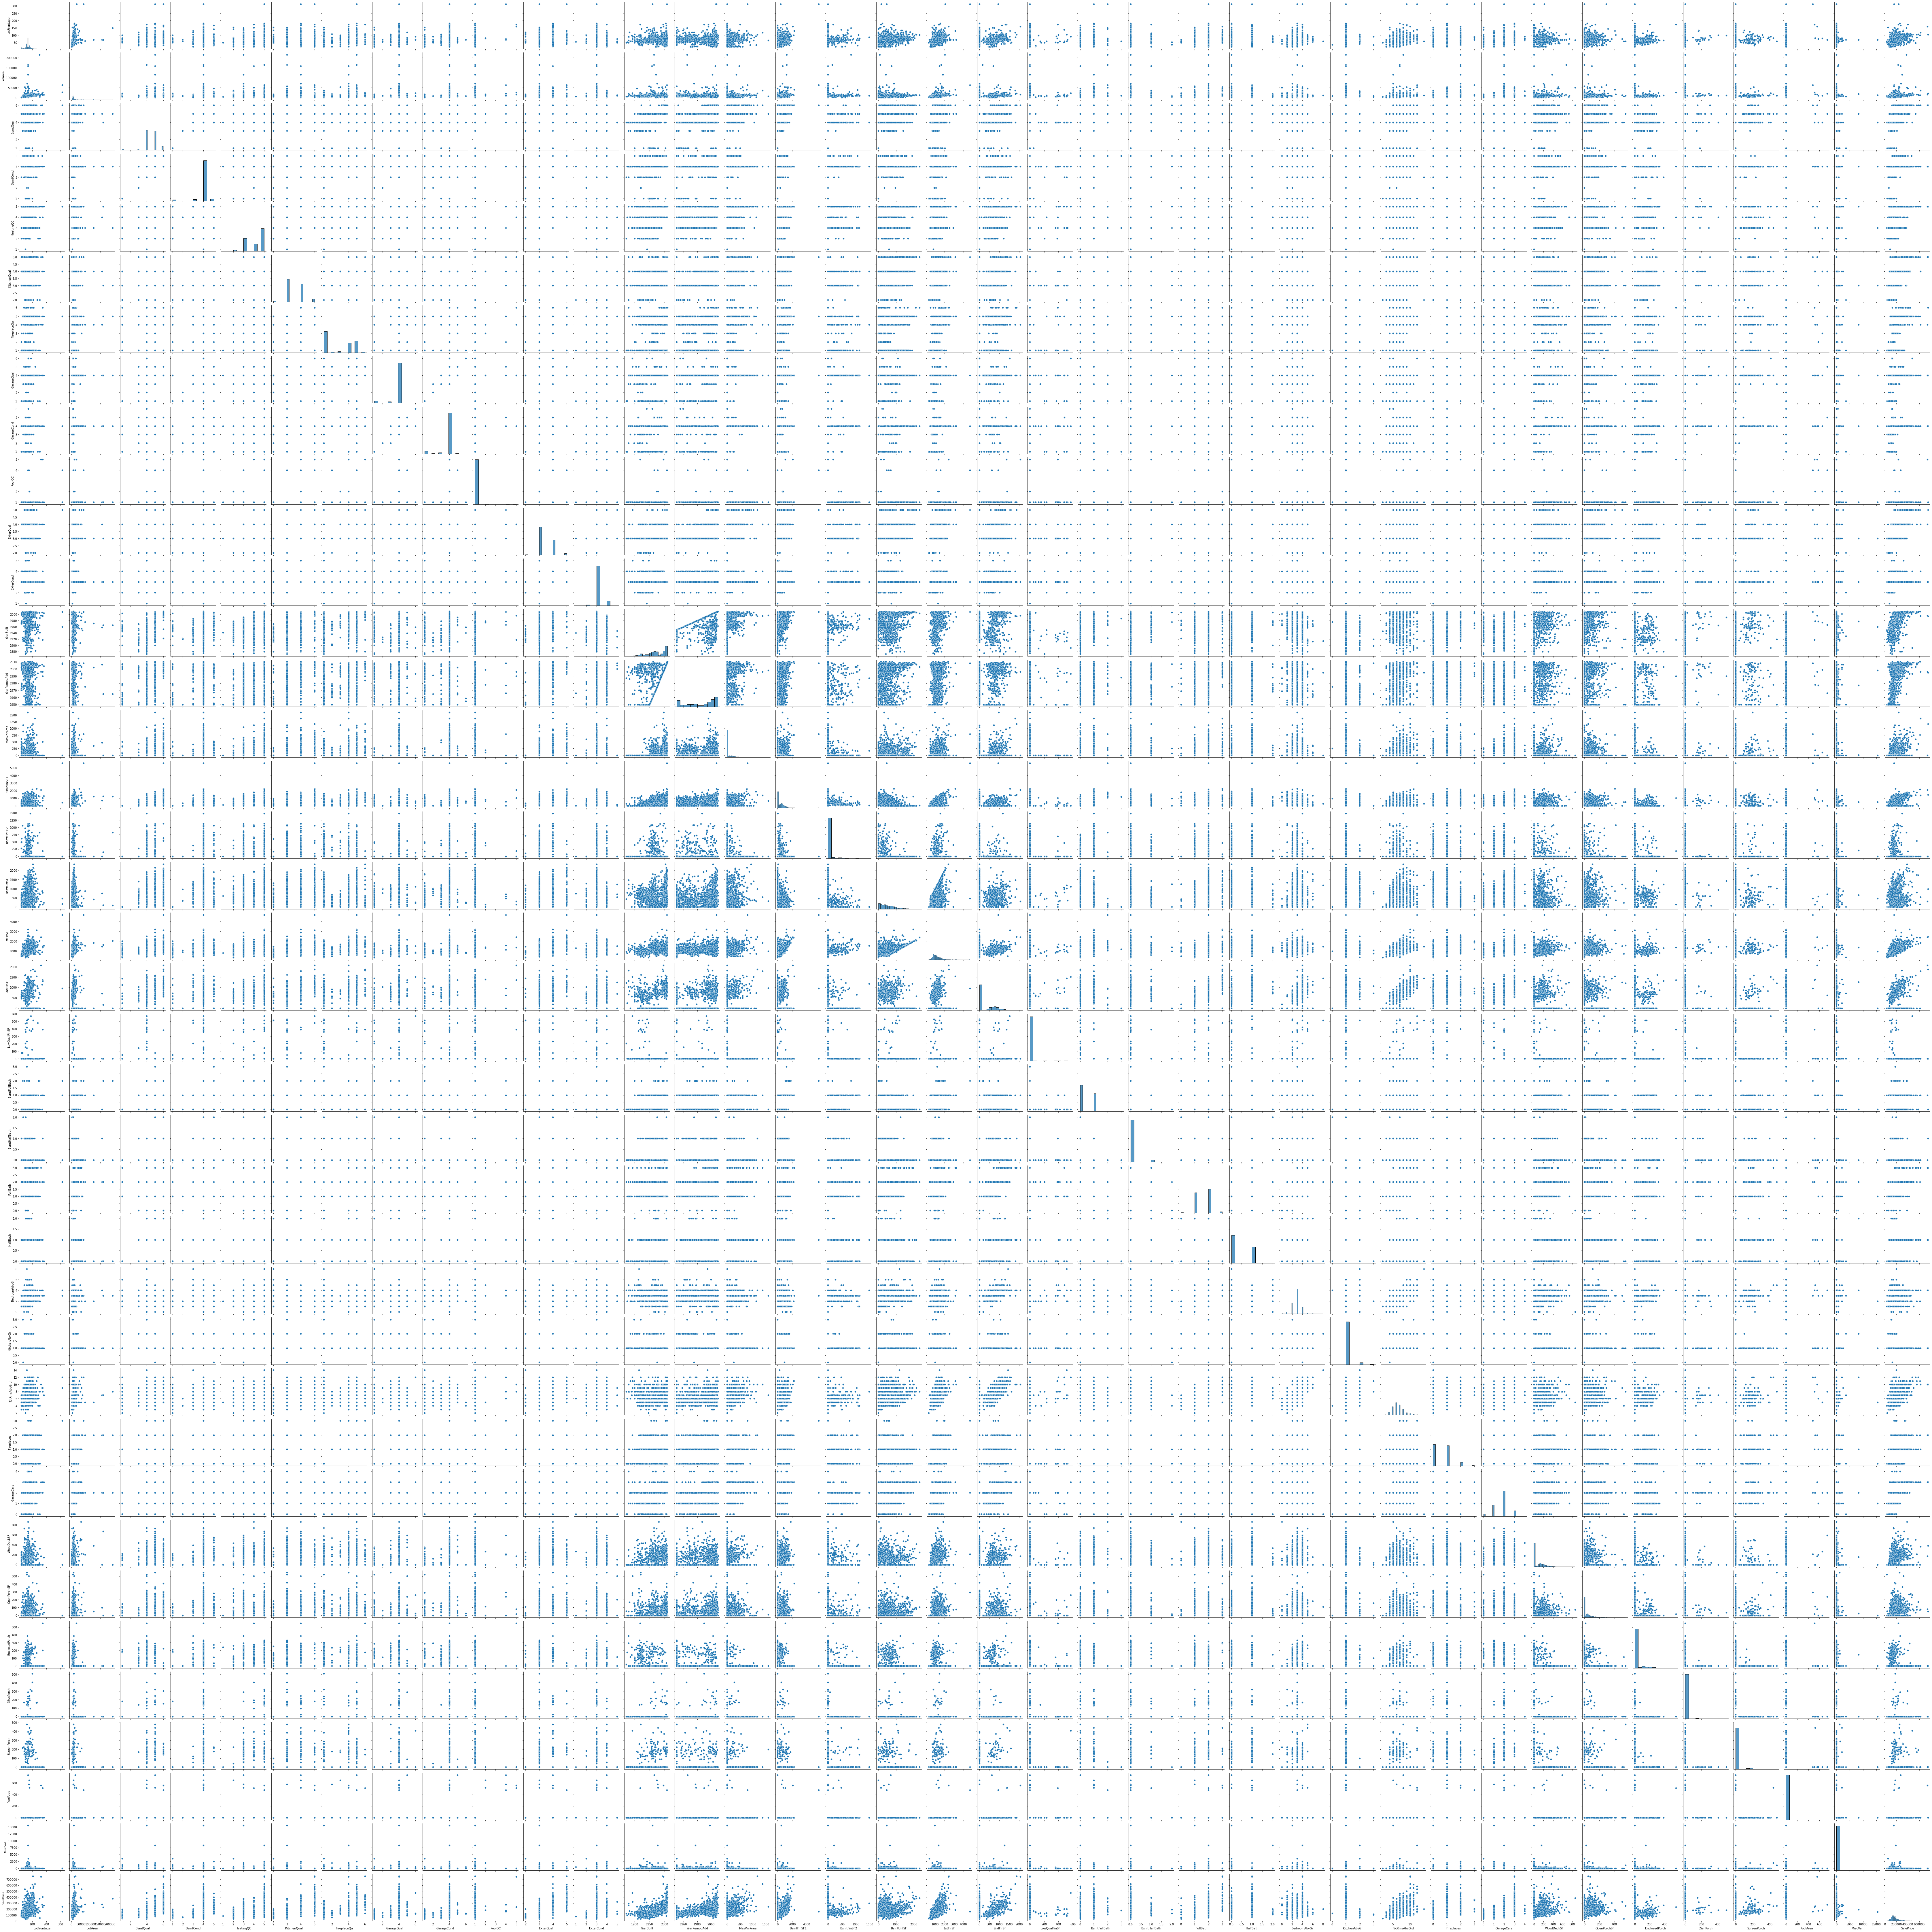

In [193]:
plt.figure(figsize = (40,40))
sns.pairplot(df[num_vars])

There is a linear relationship visible between salesprice and 1stFlrSF, 2ndFlrSF, YearBuilt YearRemodAdd. Therefore linear regression can be applied

## Modelling

#### Creation of the X , y variable and test train split

In [194]:
y = df.pop("SalePrice")
X = df

In [195]:
X

LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0            65.0     8450            7            5       2003          2003   
1            80.0     9600            6            8       1976          1976   
2            68.0    11250            7            5       2001          2002   
3            60.0     9550            7            5       1915          1970   
4            84.0    14260            8            5       2000          2000   
...           ...      ...          ...          ...        ...           ...   
1455         62.0     7917            6            5       1999          2000   
1456         85.0    13175            6            6       1978          1988   
1457         66.0     9042            7            9       1941          2006   
1458         68.0     9717            5            6       1950          1996   
1459         75.0     9937            5            6       1965          1965   

      MasVnrArea  ExterQual  ExterCond  BsmtQual  ...  GarageType_CarPort  \
0          196.0          4          3         5  ...                   0   
1            0.0          3          3         5  ...                   0   
2          162.0          4          3         5  ...                   0   
3            0.0          3          3         4  ...                   0   
4          350.0          4          3         5  ...                   0   
...          ...        ...        ...       ...  ...                 ...   
1455         0.0          3          3         5  ...                   0   
1456       119.0          3          3         5  ...                   0   
1457         0.0          5          4         4  ...                   0   
1458         0.0          3          3         4  ...                   0   
1459         0.0          4          3         4  ...                   0   

      GarageType_Detchd  GarageType_No Garage  GarageFinish_No Garage  \
0                     0                     0                       0   
1                     0                     0                       0   
2                     0                     0                       0   
3                     1                     0                       0   
4                     0                     0                       0   
...                 ...                   ...                     ...   
1455                  0                     0                       0   
1456                  0                     0                       0   
1457                  0                     0                       0   
1458                  0                     0                       0   
1459                  0                     0                       0   

      GarageFinish_RFn  GarageFinish_Unf  MasVnrType_BrkFace  MasVnrType_None  \
0                    1                 0                   1                0   
1                    1                 0                   0                1   
2                    1                 0                   1                0   
3                    0                 1                   0                1   
4                    1                 0                   1                0   
...                ...               ...                 ...              ...   
1455                 1                 0                   0                1   
1456                 0                 1                   0                0   
1457                 1                 0                   0                1   
1458                 0                 1                   0                1   
1459                 0                 0                   0                1   

      MasVnrType_None Type  MasVnrType_Stone  
0                        0                 0  
1                        0                 0  
2                        0                 0  
3                        0                 0  
4                      

In [196]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [197]:
X_train.shape

(1021, 238)

In [198]:
X_train.describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1021.000000    1021.000000  1021.000000  1021.000000  1021.000000   
mean     69.544564   10485.737512     6.091087     5.581783  1971.251714   
std      22.079518   10309.181603     1.399765     1.092048    30.345790   
min      21.000000    1477.000000     1.000000     1.000000  1872.000000   
25%      60.000000    7446.000000     5.000000     5.000000  1954.000000   
50%      69.000000    9500.000000     6.000000     5.000000  1973.000000   
75%      78.000000   11512.000000     7.000000     6.000000  2000.000000   
max     313.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   MasVnrArea    ExterQual    ExterCond     BsmtQual  ...  \
count   1021.000000  1021.000000  1021.000000  1021.000000  1021.000000  ...   
mean    1984.938296   104.489716     3.398629     3.091087     4.478942  ...   
std       20.630577   187.341089     0.571168     0.349410     0.900325  ...   
min     1950.000000     0.000000     2.000000     2.000000     1.000000  ...   
25%     1967.000000     0.000000     3.000000     3.000000     4.000000  ...   
50%     1994.000000     0.000000     3.000000     3.000000     5.000000  ...   
75%     2004.000000   158.000000     4.000000     3.000000     5.000000  ...   
max     2010.000000  1600.000000     5.000000     5.000000     6.000000  ...   

       GarageType_CarPort  GarageType_Detchd  GarageType_No Garage  \
count         1021.000000        1021.000000           1021.000000   
mean             0.006856           0.269344              0.056807   
std              0.082557           0.443836              0.231587   
min              0.000000           0.000000              0.000000   
25%              0.000000           0.000000              0.000000   
50%              0.000000           0.000000              0.000000   
75%              0.000000           1.000000              0.000000   
max              1.000000           1.000000              1.000000   

       GarageFinish_No Garage  GarageFinish_RFn  GarageFinish_Unf  \
count             1021.000000       1021.000000       1021.000000   
mean                 0.056807          0.278159          0.420176   
std                  0.231587          0.448312          0.493829   
min                  0.000000          0.000000          0.000000   
25%                  0.000000          0.000000          0.000000   
50%                  0.000000          0.000000          0.000000   
75%                  0.000000          1.000000          1.000000   
max                  1.000000          1.000000          1.000000   

       MasVnrType_BrkFace  MasVnrType_None  MasVnrType_None Type  \
count         1021.000000      1021.000000           1021.000000   
mean             0.302644         0.591577              0.003918   
std              0.459628         0.491783              0.062500   
min              0.000000         0.000000              0.000000   
25%              0.000000         0.000000              0.000000   
50%              0.000000         1.000000              0.000000   
75%              1.000000         1.000000              0.000000   
max              1.000000         1.000000              1.000000   

       MasVnrType_Stone  
count       1021.000000  
mean           0.092067  
std            0.289262  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000  

[8 rows x 238 columns]

In [199]:
X_test.describe()

LotFrontage        LotArea  OverallQual  OverallCond    YearBuilt  \
count   438.000000     438.000000   438.000000   438.000000   438.000000   
mean     70.557078   10590.664384     6.116438     5.561644  1971.248858   
std      21.914859    9194.725629     1.345440     1.161782    29.913142   
min      21.000000    1300.000000     1.000000     2.000000  1875.000000   
25%      60.000000    7752.000000     5.000000     5.000000  1954.000000   
50%      69.000000    9387.500000     6.000000     5.000000  1972.000000   
75%      80.000000   11700.000000     7.000000     6.000000  2001.000000   
max     313.000000  159000.000000    10.000000     9.000000  2009.000000   

       YearRemodAdd  MasVnrArea   ExterQual   ExterCond    BsmtQual  ...  \
count    438.000000  438.000000  438.000000  438.000000  438.000000  ...   
mean    1984.668950  100.152968    3.388128    3.066210    4.511416  ...   
std       20.717728  164.612469    0.581992    0.355023    0.819447  ...   
min     1950.000000    0.000000    2.000000    1.000000    1.000000  ...   
25%     1966.000000    0.000000    3.000000    3.000000    4.000000  ...   
50%     1993.000000    0.000000    3.000000    3.000000    5.000000  ...   
75%     2004.000000  174.000000    4.000000    3.000000    5.000000  ...   
max     2010.000000  921.000000    5.000000    5.000000    6.000000  ...   

       GarageType_CarPort  GarageType_Detchd  GarageType_No Garage  \
count          438.000000         438.000000            438.000000   
mean             0.004566           0.255708              0.052511   
std              0.067496           0.436757              0.223311   
min              0.000000           0.000000              0.000000   
25%              0.000000           0.000000              0.000000   
50%              0.000000           0.000000              0.000000   
75%              0.000000           1.000000              0.000000   
max              1.000000           1.000000              1.000000   

       GarageFinish_No Garage  GarageFinish_RFn  GarageFinish_Unf  \
count              438.000000        438.000000        438.000000   
mean                 0.052511          0.315068          0.399543   
std                  0.223311          0.465074          0.490365   
min                  0.000000          0.000000          0.000000   
25%                  0.000000          0.000000          0.000000   
50%                  0.000000          0.000000          0.000000   
75%                  0.000000          1.000000          1.000000   
max                  1.000000          1.000000          1.000000   

       MasVnrType_BrkFace  MasVnrType_None  MasVnrType_None Type  \
count          438.000000       438.000000            438.000000   
mean             0.310502         0.591324              0.009132   
std              0.463228         0.492151              0.095235   
min              0.000000         0.000000              0.000000   
25%              0.000000         0.000000              0.000000   
50%              0.000000         1.000000              0.000000   
75%              1.000000         1.000000              0.000000   
max              1.000000         1.000000              1.000000   

       MasVnrType_Stone  
count        438.000000  
mean           0.077626  
std            0.267887  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000  

[8 rows x 238 columns]

In [200]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 210 to 79
Data columns (total 238 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    LotFrontage               float64
 1    LotArea                   int64  
 2    OverallQual               int64  
 3    OverallCond               int64  
 4    YearBuilt                 int64  
 5    YearRemodAdd              int64  
 6    MasVnrArea                float64
 7    ExterQual                 int64  
 8    ExterCond                 int64  
 9    BsmtQual                  int64  
 10   BsmtCond                  int64  
 11   BsmtFinSF1                int64  
 12   BsmtFinSF2                int64  
 13   BsmtUnfSF                 int64  
 14   HeatingQC                 int64  
 15   1stFlrSF                  int64  
 16   2ndFlrSF                  int64  
 17   LowQualFinSF              int64  
 18   BsmtFullBath              int64  
 19   BsmtHalfBath              int64  
 20   FullBa

In [201]:
num_vars.remove("SalePrice")

In [202]:
X_train.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 210 to 79
Data columns (total 238 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    LotFrontage               1021 non-null   float64
 1    LotArea                   1021 non-null   int64  
 2    OverallQual               1021 non-null   int64  
 3    OverallCond               1021 non-null   int64  
 4    YearBuilt                 1021 non-null   int64  
 5    YearRemodAdd              1021 non-null   int64  
 6    MasVnrArea                1021 non-null   float64
 7    ExterQual                 1021 non-null   int64  
 8    ExterCond                 1021 non-null   int64  
 9    BsmtQual                  1021 non-null   int64  
 10   BsmtCond                  1021 non-null   int64  
 11   BsmtFinSF1                1021 non-null   int64  
 12   BsmtFinSF2                1021 non-null   int64  
 13   BsmtUnfSF                 1021 non-null   int6

In [203]:
#Scalling of the training predictor variables
scaler = StandardScaler()
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_train.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
210     -0.115302 -0.473765            5            6  -1.524903   
318      0.926898 -0.056845            7            5   0.717033   
239     -0.794998 -0.169324            6            4  -0.865510   
986     -0.477806 -0.502297            6            8  -2.019448   
1416    -0.432493  0.082905            4            6  -2.843689   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  ...  \
210      -1.694350   -0.558025  -0.698260  -0.260816 -0.532226  ...   
318       0.390956    0.809137   1.053395  -0.260816  0.579028  ...   
239      -1.694350   -0.558025  -0.698260  -0.260816 -0.532226  ...   
986       0.875911   -0.558025  -0.698260   2.602556 -0.532226  ...   
1416     -1.694350   -0.558025  -0.698260  -0.260816 -0.532226  ...   

      GarageType_CarPort  GarageType_Detchd  GarageType_No Garage  \
210                    0                  0                     1   
318                    0                  0                     0   
239                    0                  1                     0   
986                    0                  0                     0   
1416                   0                  1                     0   

      GarageFinish_No Garage  GarageFinish_RFn  GarageFinish_Unf  \
210                        1                 0                 0   
318                        0                 1                 0   
239                        0                 0                 1   
986                        0                 0                 1   
1416                       0                 0                 1   

      MasVnrType_BrkFace  MasVnrType_None  MasVnrType_None Type  \
210                    0                1                     0   
318                    1                0                     0   
239                    0                1                     0   
986                    0                1                     0   
1416                   0                1                     0   

      MasVnrType_Stone  
210                  0  
318                  0  
239                  0  
986                  0  
1416                 0  

[5 rows x 238 columns]

In [204]:
#scaling of the test predictor variables
X_test[num_vars] = scaler.transform(X_test[num_vars])
X_test.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
1436    -0.432493 -0.144189            4            6  -0.008299   
57       0.881585  0.112505            7            5   1.079700   
780     -0.296554 -0.253368            7            5   0.782973   
382      0.428455 -0.120412            7            5   1.145639   
1170     0.292515 -0.058786            6            6   0.189519   

      YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  ...  \
1436     -0.675945   -0.558025  -0.698260  -0.260816 -0.532226  ...   
57        0.924407   -0.558025   1.053395  -0.260816  0.579028  ...   
780       0.536443   -0.355087  -0.698260  -0.260816  0.579028  ...   
382       1.021398   -0.558025   1.053395  -0.260816  0.579028  ...   
1170     -0.384972   -0.558025  -0.698260  -0.260816 -0.532226  ...   

      GarageType_CarPort  GarageType_Detchd  GarageType_No Garage  \
1436                   0                  1                     0   
57                     0                  0                     0   
780                    0                  0                     0   
382                    0                  0                     0   
1170                   0                  0                     0   

      GarageFinish_No Garage  GarageFinish_RFn  GarageFinish_Unf  \
1436                       0                 0                 1   
57                         0                 1                 0   
780                        0                 0                 0   
382                        0                 1                 0   
1170                       0                 0                 0   

      MasVnrType_BrkFace  MasVnrType_None  MasVnrType_None Type  \
1436                   0                1                     0   
57                     0                1                     0   
780                    1                0                     0   
382                    0                1                     0   
1170                   0                1                     0   

      MasVnrType_Stone  
1436                 0  
57                   0  
780                  0  
382                  0  
1170                 0  

[5 rows x 238 columns]

### Ridge regression

In [205]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [206]:
print(model_cv.best_params_)

{'alpha': 50}


In [207]:
alpha = 50
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-1.09467969e+03  3.61095220e+03  1.21691221e+04  4.78963938e+03
  9.96669439e+02  1.87472887e+02  6.21376497e+03  4.64288229e+03
 -8.55658656e+02  7.48064572e+03 -2.35782425e+03  2.47968343e+03
  1.03929521e+03  1.88484511e+03  1.06543127e+03  1.35766717e+04
  1.63885100e+04 -4.32391822e+01  4.23342221e+03  4.72722408e+02
  3.58254423e+03  2.50780741e+03 -7.01925326e+02 -4.14240328e+03
  5.84133631e+03  5.14415839e+03  1.80896169e+03  2.16147118e+03
  7.53451503e+03  1.52052803e+01  8.29913159e+02 -3.44227913e+03
  1.97842314e+03 -6.45060352e+02  3.19239506e+02  1.50258083e+03
  1.05783195e+03 -1.76576964e+03  2.02046830e+03  1.58897361e+02
 -2.16766058e+02  1.66313612e+02  4.84411675e+02  2.67649402e+03
  3.33841085e+02  7.41610266e+01 -7.00683471e+02 -1.80440716e+03
 -8.13216793e+02 -6.95300457e+02 -6.42904752e+03 -5.47827172e+03
 -5.10292304e+02 -1.80716467e+03  1.44183015e+03  1.31929173e+03
  3.27942637e+03 -3.67608676e+03  1.48193689e+03  1.26149534e+03
 -4.59281470e+03 -1.50671

In [208]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8613692380963068
0.8611744527971669
884561136049.4861
391309309433.3655
866367420.224766
893400249.8478664


### Ridge regression residual analysis

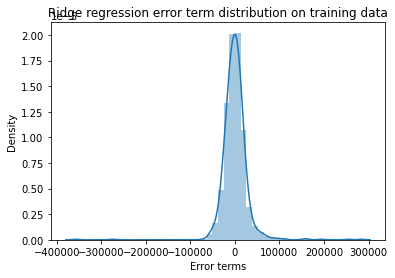

In [209]:
# Residual terms normal distribution assumption visual check
plt.figure()
sns.distplot(y_train - y_pred_train)
plt.title("Ridge regression error term distribution on training data")
plt.xlabel("Error terms")
plt.show()

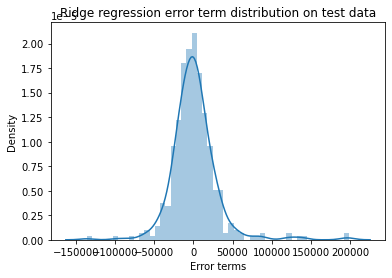

In [210]:
# Residual terms normal distribution assumption visual check
plt.figure()
sns.distplot(y_test - y_pred_test)
plt.title("Ridge regression error term distribution on test data")
plt.xlabel("Error terms")
plt.show()

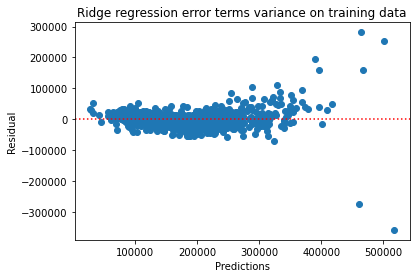

In [211]:
#Residual terms constant variance and independency visual check
plt.figure()
plt.scatter( y_pred_train , y_train-y_pred_train)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.title("Ridge regression error terms variance on training data")
plt.show()

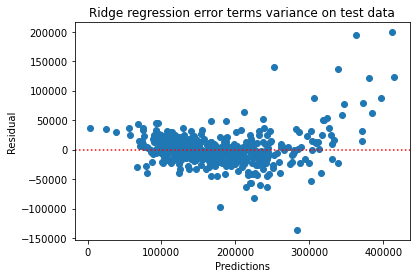

In [212]:
#Residual terms constant variance and independency visual check
plt.figure()
plt.scatter( y_pred_test , y_test-y_pred_test)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.title("Ridge regression error terms variance on test data")
plt.show()

Linearity assumptions with respect to error terms are generally satisfied

In [213]:
# Representing the variables and its coefficients
columns = list(X_train.columns)
columns.insert(0,"Intercept")
ridge_coeff = list(zip(columns,list(ridge.coef_)))
ridge_coeff

[('Intercept', -1094.6796876442022),
 ('LotFrontage', 3610.9522000103702),
 ('LotArea', 12169.122074730996),
 ('OverallQual', 4789.6393821744305),
 ('OverallCond', 996.6694392179501),
 ('YearBuilt', 187.4728873220146),
 ('YearRemodAdd', 6213.764966014131),
 ('MasVnrArea', 4642.882294576049),
 ('ExterQual', -855.6586563509885),
 ('ExterCond', 7480.645719820554),
 ('BsmtQual', -2357.8242458369496),
 ('BsmtCond', 2479.6834315930996),
 ('BsmtFinSF1', 1039.2952127997464),
 ('BsmtFinSF2', 1884.845113220589),
 ('BsmtUnfSF', 1065.4312733837762),
 ('HeatingQC', 13576.671728048837),
 ('1stFlrSF', 16388.509952478995),
 ('2ndFlrSF', -43.23918220917684),
 ('LowQualFinSF', 4233.422211854473),
 ('BsmtFullBath', 472.7224079517741),
 ('BsmtHalfBath', 3582.544225629419),
 ('FullBath', 2507.8074122332364),
 ('HalfBath', -701.92532594611),
 ('BedroomAbvGr', -4142.4032771613065),
 ('KitchenAbvGr', 5841.336310802171),
 ('KitchenQual', 5144.158392188794),
 ('TotRmsAbvGrd', 1808.9616861286595),
 ('Fireplaces'

In [214]:
ridge_coeff_sorted = sorted(ridge_coeff,key=lambda x:abs(x[1]),reverse=True)
ridge_coeff_sorted

[('1stFlrSF', 16388.509952478995),
 ('Neighborhood_NWAmes', 14814.693063695504),
 ('HeatingQC', 13576.671728048837),
 ('LotArea', 12169.122074730996),
 ('Neighborhood_NoRidge', 11980.907754429452),
 ('MiscFeature_TenC', 11227.040656072537),
 ('Neighborhood_Crawfor', -9475.61990334987),
 ('HouseStyle_1.5Unf', 9200.954757816757),
 ('Condition1_Feedr', 8215.127764588255),
 ('FireplaceQu', 7534.515029407147),
 ('ExterCond', 7480.645719820554),
 ('BsmtExposure_Mn', -7439.417294637235),
 ('Neighborhood_CollgCr', 6818.111624931724),
 ('RoofMatl_WdShake', 6686.018294273707),
 ('MSSubClass_90', -6429.047520625173),
 ('YearRemodAdd', 6213.764966014131),
 ('BldgType_Twnhs', -6128.784900379164),
 ('KitchenAbvGr', 5841.336310802171),
 ('Exterior1st_BrkComm', 5821.863984784118),
 ('BldgType_Duplex', -5684.864325385445),
 ('Neighborhood_ClearCr', -5577.0011285095015),
 ('Condition2_PosA', -5510.207764398084),
 ('MSSubClass_120', -5478.271716749876),
 ('BsmtFinType1_Rec', -5450.762101696111),
 ('Utili

### Lasso Regression

In [215]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [216]:
print(model_cv.best_params_)

{'alpha': 500}


In [217]:
alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [218]:
lasso.coef_

array([-0.00000000e+00,  3.41122933e+03,  1.31474700e+04,  4.26126183e+03,
        1.84483431e+03,  0.00000000e+00,  4.49095811e+03,  4.20711708e+03,
       -0.00000000e+00,  6.98828630e+03, -1.51651977e+03,  4.00911061e+02,
       -0.00000000e+00, -0.00000000e+00,  9.01875739e+02,  1.76235387e+04,
        1.83335027e+04,  0.00000000e+00,  4.00239219e+03,  1.43960556e+02,
        1.63127641e+03,  1.15352507e+03, -0.00000000e+00, -3.82257504e+03,
        6.37383934e+03,  2.81578304e+03,  1.25272891e+03,  2.63013767e+03,
        6.39839018e+03,  1.55842296e+01, -0.00000000e+00, -2.72743492e+03,
        1.26797688e+03, -0.00000000e+00, -0.00000000e+00,  1.22854513e+03,
        8.69724850e+02, -5.22776438e+02, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -2.99651098e+03, -3.43027898e+03,
       -0.00000000e+00, -

In [219]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8471429646126782
0.8478020536271047
975334702187.5076
429002258534.86615
955273949.2531905
979457211.2668177


### Lasso regression residual analysis

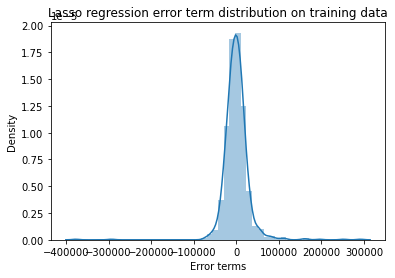

In [220]:
# Residual terms normal distribution assumption visual check
plt.figure()
sns.distplot(y_train - y_pred_train)
plt.title("Lasso regression error term distribution on training data")
plt.xlabel("Error terms")
plt.show()

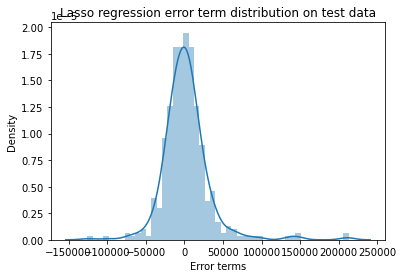

In [221]:
# Residual terms normal distribution assumption visual check
plt.figure()
sns.distplot(y_test - y_pred_test)
plt.title("Lasso regression error term distribution on test data")
plt.xlabel("Error terms")
plt.show()

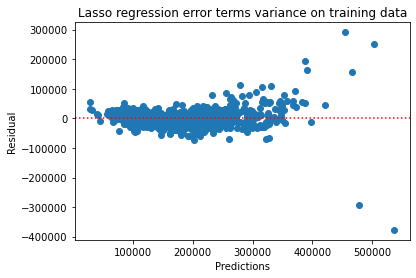

In [222]:
#Residual terms constant variance and independency visual check
plt.figure()
plt.scatter( y_pred_train , y_train-y_pred_train)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.title("Lasso regression error terms variance on training data")
plt.show()

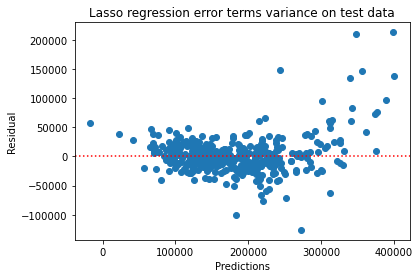

In [223]:
#Residual terms constant variance and independency visual check
plt.figure()
plt.scatter( y_pred_test , y_test-y_pred_test)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.title("Lasso regression error terms variance on test data")
plt.show()

In [224]:
# Representing the variables and its coefficients
columns = list(X_train.columns)
columns.insert(0,"Intercept")
lasso_coeff = list(zip(columns,list(lasso.coef_)))
lasso_coeff

[('Intercept', -0.0),
 ('LotFrontage', 3411.2293295881973),
 ('LotArea', 13147.46996220356),
 ('OverallQual', 4261.261825783209),
 ('OverallCond', 1844.8343075012403),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 4490.9581137074065),
 ('MasVnrArea', 4207.117083573317),
 ('ExterQual', -0.0),
 ('ExterCond', 6988.286302991216),
 ('BsmtQual', -1516.5197708535868),
 ('BsmtCond', 400.9110605377292),
 ('BsmtFinSF1', -0.0),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 901.8757388324813),
 ('HeatingQC', 17623.53871707697),
 ('1stFlrSF', 18333.502715605788),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 4002.392194979536),
 ('BsmtFullBath', 143.96055608737387),
 ('BsmtHalfBath', 1631.276408103845),
 ('FullBath', 1153.5250715315021),
 ('HalfBath', -0.0),
 ('BedroomAbvGr', -3822.575036418768),
 ('KitchenAbvGr', 6373.839337387743),
 ('KitchenQual', 2815.783036133294),
 ('TotRmsAbvGrd', 1252.7289134147313),
 ('Fireplaces', 2630.137671048894),
 ('FireplaceQu', 6398.390181963901),
 ('GarageCars', 15.584229579736698),
 ('G

In [225]:
lasso_coeff_sorted = sorted(lasso_coeff,key=lambda x:abs(x[1]),reverse=True)
lasso_coeff_sorted

[('Neighborhood_NWAmes', 30631.651397175414),
 ('1stFlrSF', 18333.502715605788),
 ('Neighborhood_NoRidge', 17926.372963751568),
 ('HeatingQC', 17623.53871707697),
 ('MiscFeature_TenC', 13789.70510419888),
 ('LotArea', 13147.46996220356),
 ('HouseStyle_1.5Unf', 11304.670631923722),
 ('Condition1_Feedr', 8116.873397549589),
 ('Neighborhood_Crawfor', -7291.010552239566),
 ('BsmtExposure_Mn', -7030.789845064342),
 ('ExterCond', 6988.286302991216),
 ('FireplaceQu', 6398.390181963901),
 ('KitchenAbvGr', 6373.839337387743),
 ('MSZoning_RL', -6336.95791657233),
 ('SaleType_ConLw', 5868.937727241342),
 ('BsmtFinType1_Rec', -4822.7609603061055),
 ('YearRemodAdd', 4490.9581137074065),
 ('MasVnrType_BrkFace', 4468.2802908791655),
 ('OverallQual', 4261.261825783209),
 ('MasVnrArea', 4207.117083573317),
 ('LowQualFinSF', 4002.392194979536),
 ('BedroomAbvGr', -3822.575036418768),
 ('GarageFinish_No Garage', -3581.4947227622583),
 ('MSSubClass_120', -3430.2789838366107),
 ('LotFrontage', 3411.22932958

In [226]:
# Finding the relevant co-efficient
lasso_relavant_coeff = []
for tup in lasso_coeff_sorted:
    if (abs(tup[1]) > 0):
        lasso_relavant_coeff.append(tup[0])

In [227]:
print(lasso_relavant_coeff)
print(len(lasso_relavant_coeff))

['Neighborhood_NWAmes', '1stFlrSF', 'Neighborhood_NoRidge', 'HeatingQC', 'MiscFeature_TenC', 'LotArea', 'HouseStyle_1.5Unf', 'Condition1_Feedr', 'Neighborhood_Crawfor', 'BsmtExposure_Mn', 'ExterCond', 'FireplaceQu', 'KitchenAbvGr', 'MSZoning_RL', 'SaleType_ConLw', 'BsmtFinType1_Rec', 'YearRemodAdd', 'MasVnrType_BrkFace', 'OverallQual', 'MasVnrArea', 'LowQualFinSF', 'BedroomAbvGr', 'GarageFinish_No Garage', 'MSSubClass_120', 'LotFrontage', 'Utilities_NoSeWa', 'MSSubClass_90', 'KitchenQual', 'GarageQual', 'Fireplaces', 'GarageFinish_RFn', 'BldgType_Twnhs', 'OverallCond', 'Neighborhood_CollgCr', 'BsmtHalfBath', 'BsmtQual', 'BsmtFinType1_BLQ', 'GarageCond', 'TotRmsAbvGrd', 'EnclosedPorch', 'FullBath', 'BsmtUnfSF', '3SsnPorch', 'HouseStyle_SLvl', 'Exterior2nd_Stucco', 'ScreenPorch', 'BsmtFinType2_Unf', 'HouseStyle_2.5Unf', 'BsmtCond', 'Neighborhood_SawyerW', 'BsmtFullBath', 'Exterior1st_BrkComm', 'GarageCars']
53


## Conclusion

- Regression results

    -Ridge regression results

    ++++++++++++++++++++++++++++

        -Train R2 score = 0.8613

        -Test R2 score  = 0.8611

        -Optimal lambda = 50


    -Lasso regression results

    ++++++++++++++++++++++++

        -Train R2 score = 0.8471

        -Test R2 score  = 0.8478

        -Optimal lambda = 500

- Ridge regression is preferred for prediction due to better R2 score
- Lasso regression to explain the predictor influence
- Lasso regression concludes total of 53 relevant predictors (including dummies) which are below and are aranged in the order of their highest influence

    ['Neighborhood_NWAmes', '1stFlrSF', 'Neighborhood_NoRidge', 'HeatingQC', 'MiscFeature_TenC', 'LotArea', 'HouseStyle_1.5Unf', 'Condition1_Feedr', 'Neighborhood_Crawfor', 'BsmtExposure_Mn', 'ExterCond', 'FireplaceQu', 'KitchenAbvGr', 'MSZoning_RL', 'SaleType_ConLw', 'BsmtFinType1_Rec', 'YearRemodAdd', 'MasVnrType_BrkFace', 'OverallQual', 'MasVnrArea', 'LowQualFinSF', 'BedroomAbvGr', 'GarageFinish_No Garage', 'MSSubClass_120', 'LotFrontage', 'Utilities_NoSeWa', 'MSSubClass_90', 'KitchenQual', 'GarageQual', 'Fireplaces', 'GarageFinish_RFn', 'BldgType_Twnhs', 'OverallCond', 'Neighborhood_CollgCr', 'BsmtHalfBath', 'BsmtQual', 'BsmtFinType1_BLQ', 'GarageCond', 'TotRmsAbvGrd', 'EnclosedPorch', 'FullBath', 'BsmtUnfSF', '3SsnPorch', 'HouseStyle_SLvl', 'Exterior2nd_Stucco', 'ScreenPorch', 'BsmtFinType2_Unf', 'HouseStyle_2.5Unf', 'BsmtCond', 'Neighborhood_SawyerW', 'BsmtFullBath', 'Exterior1st_BrkComm', 'GarageCars']
    

- Residual error terms are checked for assumption confirmation. Error term normality is confirmed but constant variance is not ideal visually. Any non-linear relationship could be checked if needed

## Below code are to answer the part II questions of the assignment

In [228]:
#Question1

alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)


Ridge(alpha=100)

In [229]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8485402304407728
0.8559317455264303
966419169795.6342
406086994110.3495
946541792.1602685
927139255.959702


In [230]:
# Representing the variables and its coefficients
columns = list(X_train.columns)
columns.insert(0,"Intercept")
ridge_coeff = list(zip(columns,list(ridge.coef_)))
ridge_coeff

[('Intercept', -298.1881217347416),
 ('LotFrontage', 3636.417601684628),
 ('LotArea', 12376.449474477706),
 ('OverallQual', 4509.843672121554),
 ('OverallCond', 979.7953218172943),
 ('YearBuilt', 553.6823085854087),
 ('YearRemodAdd', 6249.931740479089),
 ('MasVnrArea', 5060.69386842555),
 ('ExterQual', -659.9784649890294),
 ('ExterCond', 6795.157256921203),
 ('BsmtQual', -2272.402563935418),
 ('BsmtCond', 3478.236722081721),
 ('BsmtFinSF1', 1183.0057843935263),
 ('BsmtFinSF2', 2181.032838845857),
 ('BsmtUnfSF', 1203.702436871179),
 ('HeatingQC', 11909.760687411559),
 ('1stFlrSF', 12409.00366216049),
 ('2ndFlrSF', -127.4415843691682),
 ('LowQualFinSF', 3979.147912818722),
 ('BsmtFullBath', 400.39612122175754),
 ('BsmtHalfBath', 3843.1464118346307),
 ('FullBath', 2740.2698476437226),
 ('HalfBath', -228.37548168286114),
 ('BedroomAbvGr', -3886.064058242757),
 ('KitchenAbvGr', 5967.922816248666),
 ('KitchenQual', 5553.641632906448),
 ('TotRmsAbvGrd', 2191.0275018632437),
 ('Fireplaces', 25

In [231]:
ridge_coeff_sorted = sorted(ridge_coeff,key=lambda x:abs(x[1]),reverse=True)
ridge_coeff_sorted

[('1stFlrSF', 12409.00366216049),
 ('LotArea', 12376.449474477706),
 ('HeatingQC', 11909.760687411559),
 ('Neighborhood_NWAmes', 9823.923592479325),
 ('MiscFeature_TenC', 8251.191392515067),
 ('Neighborhood_NoRidge', 7271.7040849539435),
 ('ExterCond', 6795.157256921203),
 ('Condition1_Feedr', 6508.488054621728),
 ('BsmtExposure_Mn', -6284.286124227065),
 ('YearRemodAdd', 6249.931740479089),
 ('Neighborhood_Crawfor', -6147.090331430524),
 ('FireplaceQu', 6125.306583177648),
 ('KitchenAbvGr', 5967.922816248666),
 ('HouseStyle_1.5Unf', 5805.713495824007),
 ('KitchenQual', 5553.641632906448),
 ('MasVnrArea', 5060.69386842555),
 ('OverallQual', 4509.843672121554),
 ('BsmtFinType1_Rec', -4422.700661912588),
 ('Neighborhood_CollgCr', 4294.904678440221),
 ('BldgType_Twnhs', -4167.807726954107),
 ('GarageFinish_No Garage', -4108.029880317981),
 ('Neighborhood_ClearCr', -4051.2659265941898),
 ('LowQualFinSF', 3979.147912818722),
 ('MasVnrType_BrkFace', 3978.011130768134),
 ('MSSubClass_90', -39

In [232]:
alpha =1000
lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 


Lasso(alpha=1000)

In [233]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8238168932126906
0.8345742264753553
1124171337965.9255
466287700676.81024
1101049302.6110926
1064583791.4995668


In [234]:
# Representing the variables and its coefficients
columns = list(X_train.columns)
columns.insert(0,"Intercept")
lasso_coeff = list(zip(columns,list(lasso.coef_)))
lasso_coeff

[('Intercept', 0.0),
 ('LotFrontage', 3786.802056638058),
 ('LotArea', 14346.965990749975),
 ('OverallQual', 3090.760299217326),
 ('OverallCond', 2090.987758586013),
 ('YearBuilt', 183.05086233961805),
 ('YearRemodAdd', 4130.914227820306),
 ('MasVnrArea', 5443.16876259381),
 ('ExterQual', -0.0),
 ('ExterCond', 6562.014967047164),
 ('BsmtQual', -678.4461166669822),
 ('BsmtCond', 1685.252255608745),
 ('BsmtFinSF1', 0.0),
 ('BsmtFinSF2', -0.0),
 ('BsmtUnfSF', 998.0118443795702),
 ('HeatingQC', 17801.30556962397),
 ('1stFlrSF', 14878.841547271184),
 ('2ndFlrSF', 0.0),
 ('LowQualFinSF', 3532.6056844313453),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', 1061.0238829467498),
 ('FullBath', 711.519458019055),
 ('HalfBath', -0.0),
 ('BedroomAbvGr', -2965.9004824944395),
 ('KitchenAbvGr', 6666.754556647175),
 ('KitchenQual', 3141.796734520736),
 ('TotRmsAbvGrd', 865.5228394968968),
 ('Fireplaces', 3453.1924328137707),
 ('FireplaceQu', 4308.820295855574),
 ('GarageCars', 29.940177012071445),
 ('Garage

In [235]:
lasso_coeff_sorted = sorted(lasso_coeff,key=lambda x:abs(x[1]),reverse=True)
lasso_coeff_sorted

[('HeatingQC', 17801.30556962397),
 ('1stFlrSF', 14878.841547271184),
 ('LotArea', 14346.965990749975),
 ('Neighborhood_NWAmes', 12981.255315484404),
 ('MiscFeature_TenC', 7502.370922361604),
 ('KitchenAbvGr', 6666.754556647175),
 ('ExterCond', 6562.014967047164),
 ('BsmtExposure_Mn', -5884.206262642689),
 ('MasVnrArea', 5443.16876259381),
 ('Condition1_Feedr', 4480.923003088463),
 ('FireplaceQu', 4308.820295855574),
 ('YearRemodAdd', 4130.914227820306),
 ('HouseStyle_1.5Unf', 4052.363609622948),
 ('LotFrontage', 3786.802056638058),
 ('LowQualFinSF', 3532.6056844313453),
 ('Fireplaces', 3453.1924328137707),
 ('KitchenQual', 3141.796734520736),
 ('OverallQual', 3090.760299217326),
 ('BedroomAbvGr', -2965.9004824944395),
 ('MSZoning_RL', -2950.4349860289026),
 ('GarageQual', -2881.822376177269),
 ('BsmtFinType1_Rec', -2751.5124264110727),
 ('Neighborhood_NoRidge', 2327.5736605359903),
 ('OverallCond', 2090.987758586013),
 ('BsmtCond', 1685.252255608745),
 ('GarageCond', 1535.875591194662

In [236]:
#Question 3
X_train_part2 = X_train.drop(labels=["HeatingQC","1stFlrSF","LotArea","Neighborhood_NWAmes","MiscFeature_TenC"],axis="columns")


In [237]:
X_test_part2 = X_test.drop(labels=["HeatingQC","1stFlrSF","LotArea","Neighborhood_NWAmes","MiscFeature_TenC"],axis="columns")

In [238]:

lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_part2, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [239]:
print(model_cv.best_params_)

{'alpha': 500}


In [240]:
alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_part2, y_train) 

Lasso(alpha=500)

In [241]:
y_pred_train = lasso.predict(X_train_part2)
y_pred_test = lasso.predict(X_test_part2)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8412757011660963
0.846346748826261
1012771943017.3289
433104344412.48303
991941178.2735837
988822704.1380891


In [242]:
# Representing the variables and its coefficients
columns = list(X_train_part2.columns)
columns.insert(0,"Intercept")
lasso_coeff = list(zip(columns,list(lasso.coef_)))
lasso_coeff

[('Intercept', 392.08752232413815),
 ('LotFrontage', 14446.808986231314),
 ('OverallQual', 4139.443320225649),
 ('OverallCond', 0.0),
 ('YearBuilt', 92.61182298010043),
 ('YearRemodAdd', 5217.518297372468),
 ('MasVnrArea', 3934.1692745015903),
 ('ExterQual', -0.0),
 ('ExterCond', 6169.195949733846),
 ('BsmtQual', -3293.369957832783),
 ('BsmtCond', 8933.785408874617),
 ('BsmtFinSF1', 2652.302900153159),
 ('BsmtFinSF2', 6809.457454883292),
 ('BsmtUnfSF', 12616.008463150309),
 ('2ndFlrSF', -0.0),
 ('LowQualFinSF', 4290.73811763933),
 ('BsmtFullBath', 137.06785142904604),
 ('BsmtHalfBath', 4614.934413810838),
 ('FullBath', 2089.0204647290248),
 ('HalfBath', -0.0),
 ('BedroomAbvGr', -3953.414451783281),
 ('KitchenAbvGr', 7377.972963677585),
 ('KitchenQual', 9186.294894713279),
 ('TotRmsAbvGrd', 3544.038032973064),
 ('Fireplaces', 2117.3690745014155),
 ('FireplaceQu', 4737.63073471058),
 ('GarageCars', 32.144916117068355),
 ('GarageArea', -0.0),
 ('GarageQual', -2225.5670489965414),
 ('Garag

In [243]:
lasso_coeff_sorted = sorted(lasso_coeff,key=lambda x:abs(x[1]),reverse=True)
lasso_coeff_sorted

[('Neighborhood_NPkVill', 35347.81241300631),
 ('MiscFeature_Shed', 16731.733077287885),
 ('Neighborhood_NoRidge', 14998.980713532004),
 ('HouseStyle_1.5Unf', 14750.251774178707),
 ('LotFrontage', 14446.808986231314),
 ('BsmtUnfSF', 12616.008463150309),
 ('KitchenQual', 9186.294894713279),
 ('BsmtCond', 8933.785408874617),
 ('BsmtExposure_Mn', -8649.116947528133),
 ('KitchenAbvGr', 7377.972963677585),
 ('Condition1_Feedr', 6825.587991664168),
 ('BsmtFinSF2', 6809.457454883292),
 ('MSZoning_RL', -6589.670273305683),
 ('SaleType_ConLw', 6548.40672380471),
 ('ExterCond', 6169.195949733846),
 ('Utilities_NoSeWa', 5854.644669671222),
 ('MasVnrType_BrkFace', 5379.221618593436),
 ('YearRemodAdd', 5217.518297372468),
 ('Exterior1st_BrkComm', 5061.748792937009),
 ('Neighborhood_Crawfor', -4878.067568092577),
 ('HouseStyle_2.5Unf', -4872.4127846986585),
 ('FireplaceQu', 4737.63073471058),
 ('BsmtHalfBath', 4614.934413810838),
 ('LowQualFinSF', 4290.73811763933),
 ('GarageFinish_No Garage', -4206

In [244]:
labels_to_drop = ["HeatingQC","1stFlrSF","LotArea","Neighborhood_Blueste","Neighborhood_BrDale","Neighborhood_BrkSide","Neighborhood_ClearCr","Neighborhood_ClearCr","Neighborhood_CollgCr","Neighborhood_Crawfor","Neighborhood_Edwards","Neighborhood_Gilbert","Neighborhood_IDOTRR","Neighborhood_MeadowV","Neighborhood_Mitchel","Neighborhood_NAmes","Neighborhood_NPkVill","Neighborhood_NWAmes","Neighborhood_NoRidge","Neighborhood_NridgHt","Neighborhood_OldTown","Neighborhood_SWISU","Neighborhood_Sawyer","Neighborhood_SawyerW","Neighborhood_Somerst","Neighborhood_StoneBr","Neighborhood_Timber","Neighborhood_Veenker","MiscFeature_None","MiscFeature_Othr","MiscFeature_Shed","MiscFeature_TenC"]
X_train_part2 = X_train.drop(labels=labels_to_drop, axis="columns")

In [245]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train_part2, y_train) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1,
                                   0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                                   2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,
                                   20, 50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [246]:
print(model_cv.best_params_)

{'alpha': 500}


In [247]:
alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_part2, y_train) 

Lasso(alpha=500)

In [248]:
X_test_part2 = X_test.drop(labels=labels_to_drop, axis="columns")

In [249]:
y_pred_train = lasso.predict(X_train_part2)
y_pred_test = lasso.predict(X_test_part2)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8283128549255352
0.8436206622698569
1095483960462.2831
440788398747.83887
1072951969.1109531
1006366207.1868467


In [250]:
# Representing the variables and its coefficients
columns = list(X_train_part2.columns)
columns.insert(0,"Intercept")
lasso_coeff = list(zip(columns,list(lasso.coef_)))
lasso_coeff

[('Intercept', 488.56002537114546),
 ('LotFrontage', 15070.766923630445),
 ('OverallQual', 4148.131264589461),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemodAdd', 7192.598282062742),
 ('MasVnrArea', 4996.589678542462),
 ('ExterQual', -0.0),
 ('ExterCond', 6264.858615943796),
 ('BsmtQual', -3777.6727292687165),
 ('BsmtCond', 9704.425987052822),
 ('BsmtFinSF1', 2864.031876974415),
 ('BsmtFinSF2', 7662.082770698384),
 ('BsmtUnfSF', 14604.19170275483),
 ('2ndFlrSF', -0.0),
 ('LowQualFinSF', 4249.695151985139),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', 3946.779033796404),
 ('FullBath', 1704.7923138541616),
 ('HalfBath', -0.0),
 ('BedroomAbvGr', -4068.0759838051163),
 ('KitchenAbvGr', 7222.622928225859),
 ('KitchenQual', 9038.355003860263),
 ('TotRmsAbvGrd', 3365.3626927437763),
 ('Fireplaces', 2466.2812556084514),
 ('FireplaceQu', 5864.537084379173),
 ('GarageCars', 31.996560211637686),
 ('GarageArea', -0.0),
 ('GarageQual', -2800.4200233027277),
 ('GarageCond', 2364.281149926177)

In [251]:
lasso_coeff_sorted = sorted(lasso_coeff,key=lambda x:abs(x[1]),reverse=True)
lasso_coeff_sorted

[('Fence_No Fence', 15708.635682679951),
 ('HouseStyle_1.5Unf', 15317.773394348873),
 ('LotFrontage', 15070.766923630445),
 ('BsmtUnfSF', 14604.19170275483),
 ('BsmtCond', 9704.425987052822),
 ('KitchenQual', 9038.355003860263),
 ('Condition1_Feedr', 8593.981472824618),
 ('BsmtFinSF2', 7662.082770698384),
 ('BsmtExposure_Mn', -7496.940574419927),
 ('KitchenAbvGr', 7222.622928225859),
 ('YearRemodAdd', 7192.598282062742),
 ('Exterior1st_BrkComm', 6572.796355222191),
 ('MasVnrType_BrkFace', 6281.964834289436),
 ('ExterCond', 6264.858615943796),
 ('Utilities_NoSeWa', 6163.477012452572),
 ('FireplaceQu', 5864.537084379173),
 ('MSZoning_RL', -5858.947055436147),
 ('HouseStyle_2.5Unf', -5441.46825152656),
 ('MasVnrArea', 4996.589678542462),
 ('SaleType_ConLw', 4290.733202405834),
 ('BsmtFinType1_Rec', -4262.222865267389),
 ('LowQualFinSF', 4249.695151985139),
 ('OverallQual', 4148.131264589461),
 ('BedroomAbvGr', -4068.0759838051163),
 ('BsmtHalfBath', 3946.779033796404),
 ('MSSubClass_120',